# Missing data management

### 1. Load in the data

In [90]:
import pandas as pd
data = pd.read_csv("bodyfat.csv")
data.describe()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


### 2. Check the feature distribution

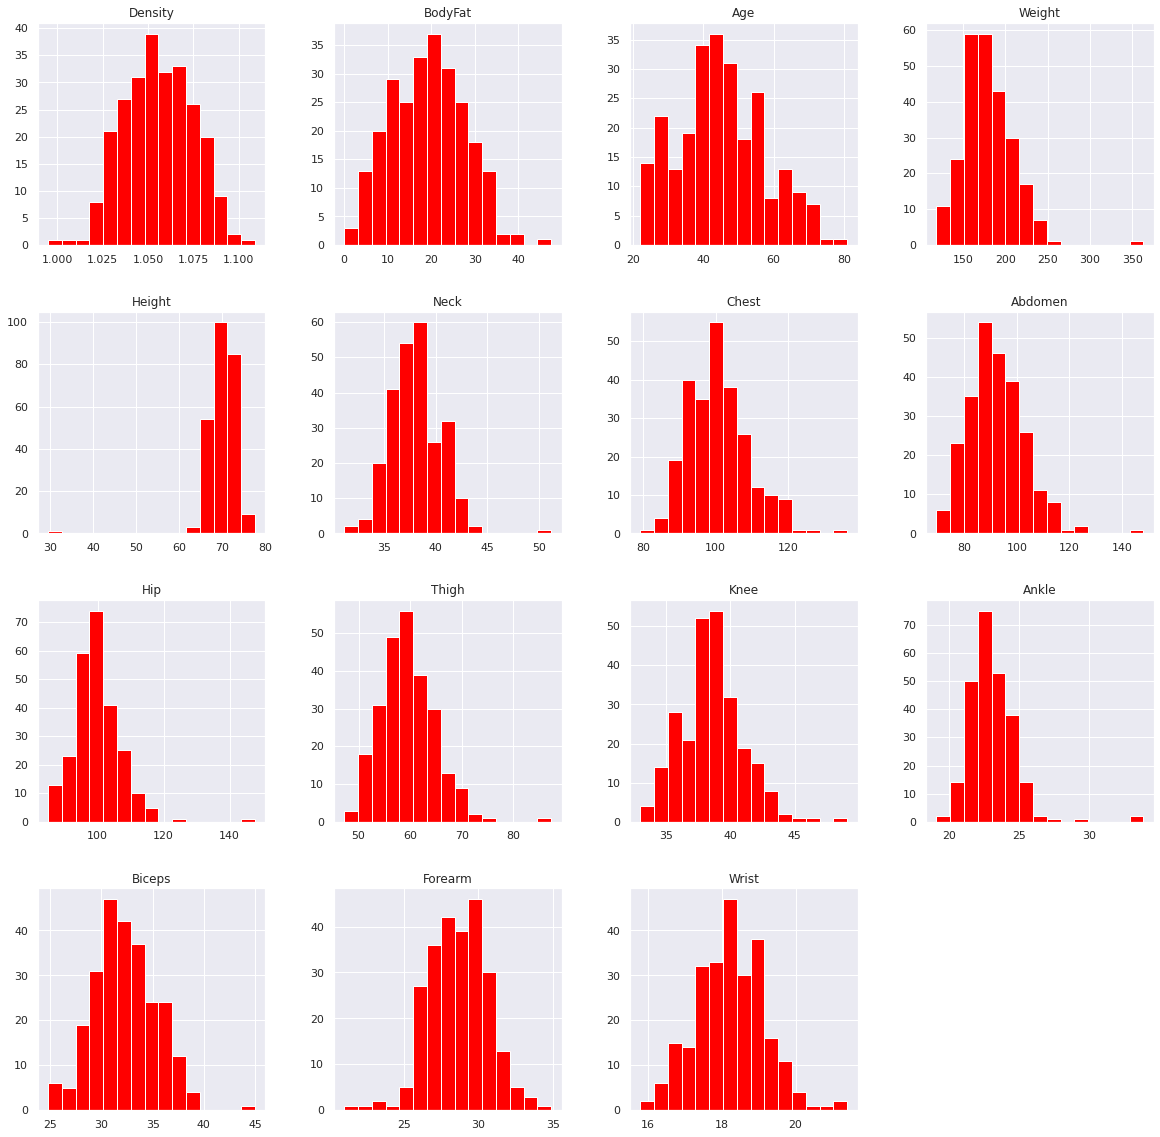

In [91]:
data.hist(figsize=(20,20),grid=True,color='red',bins=15);
d = data.copy()

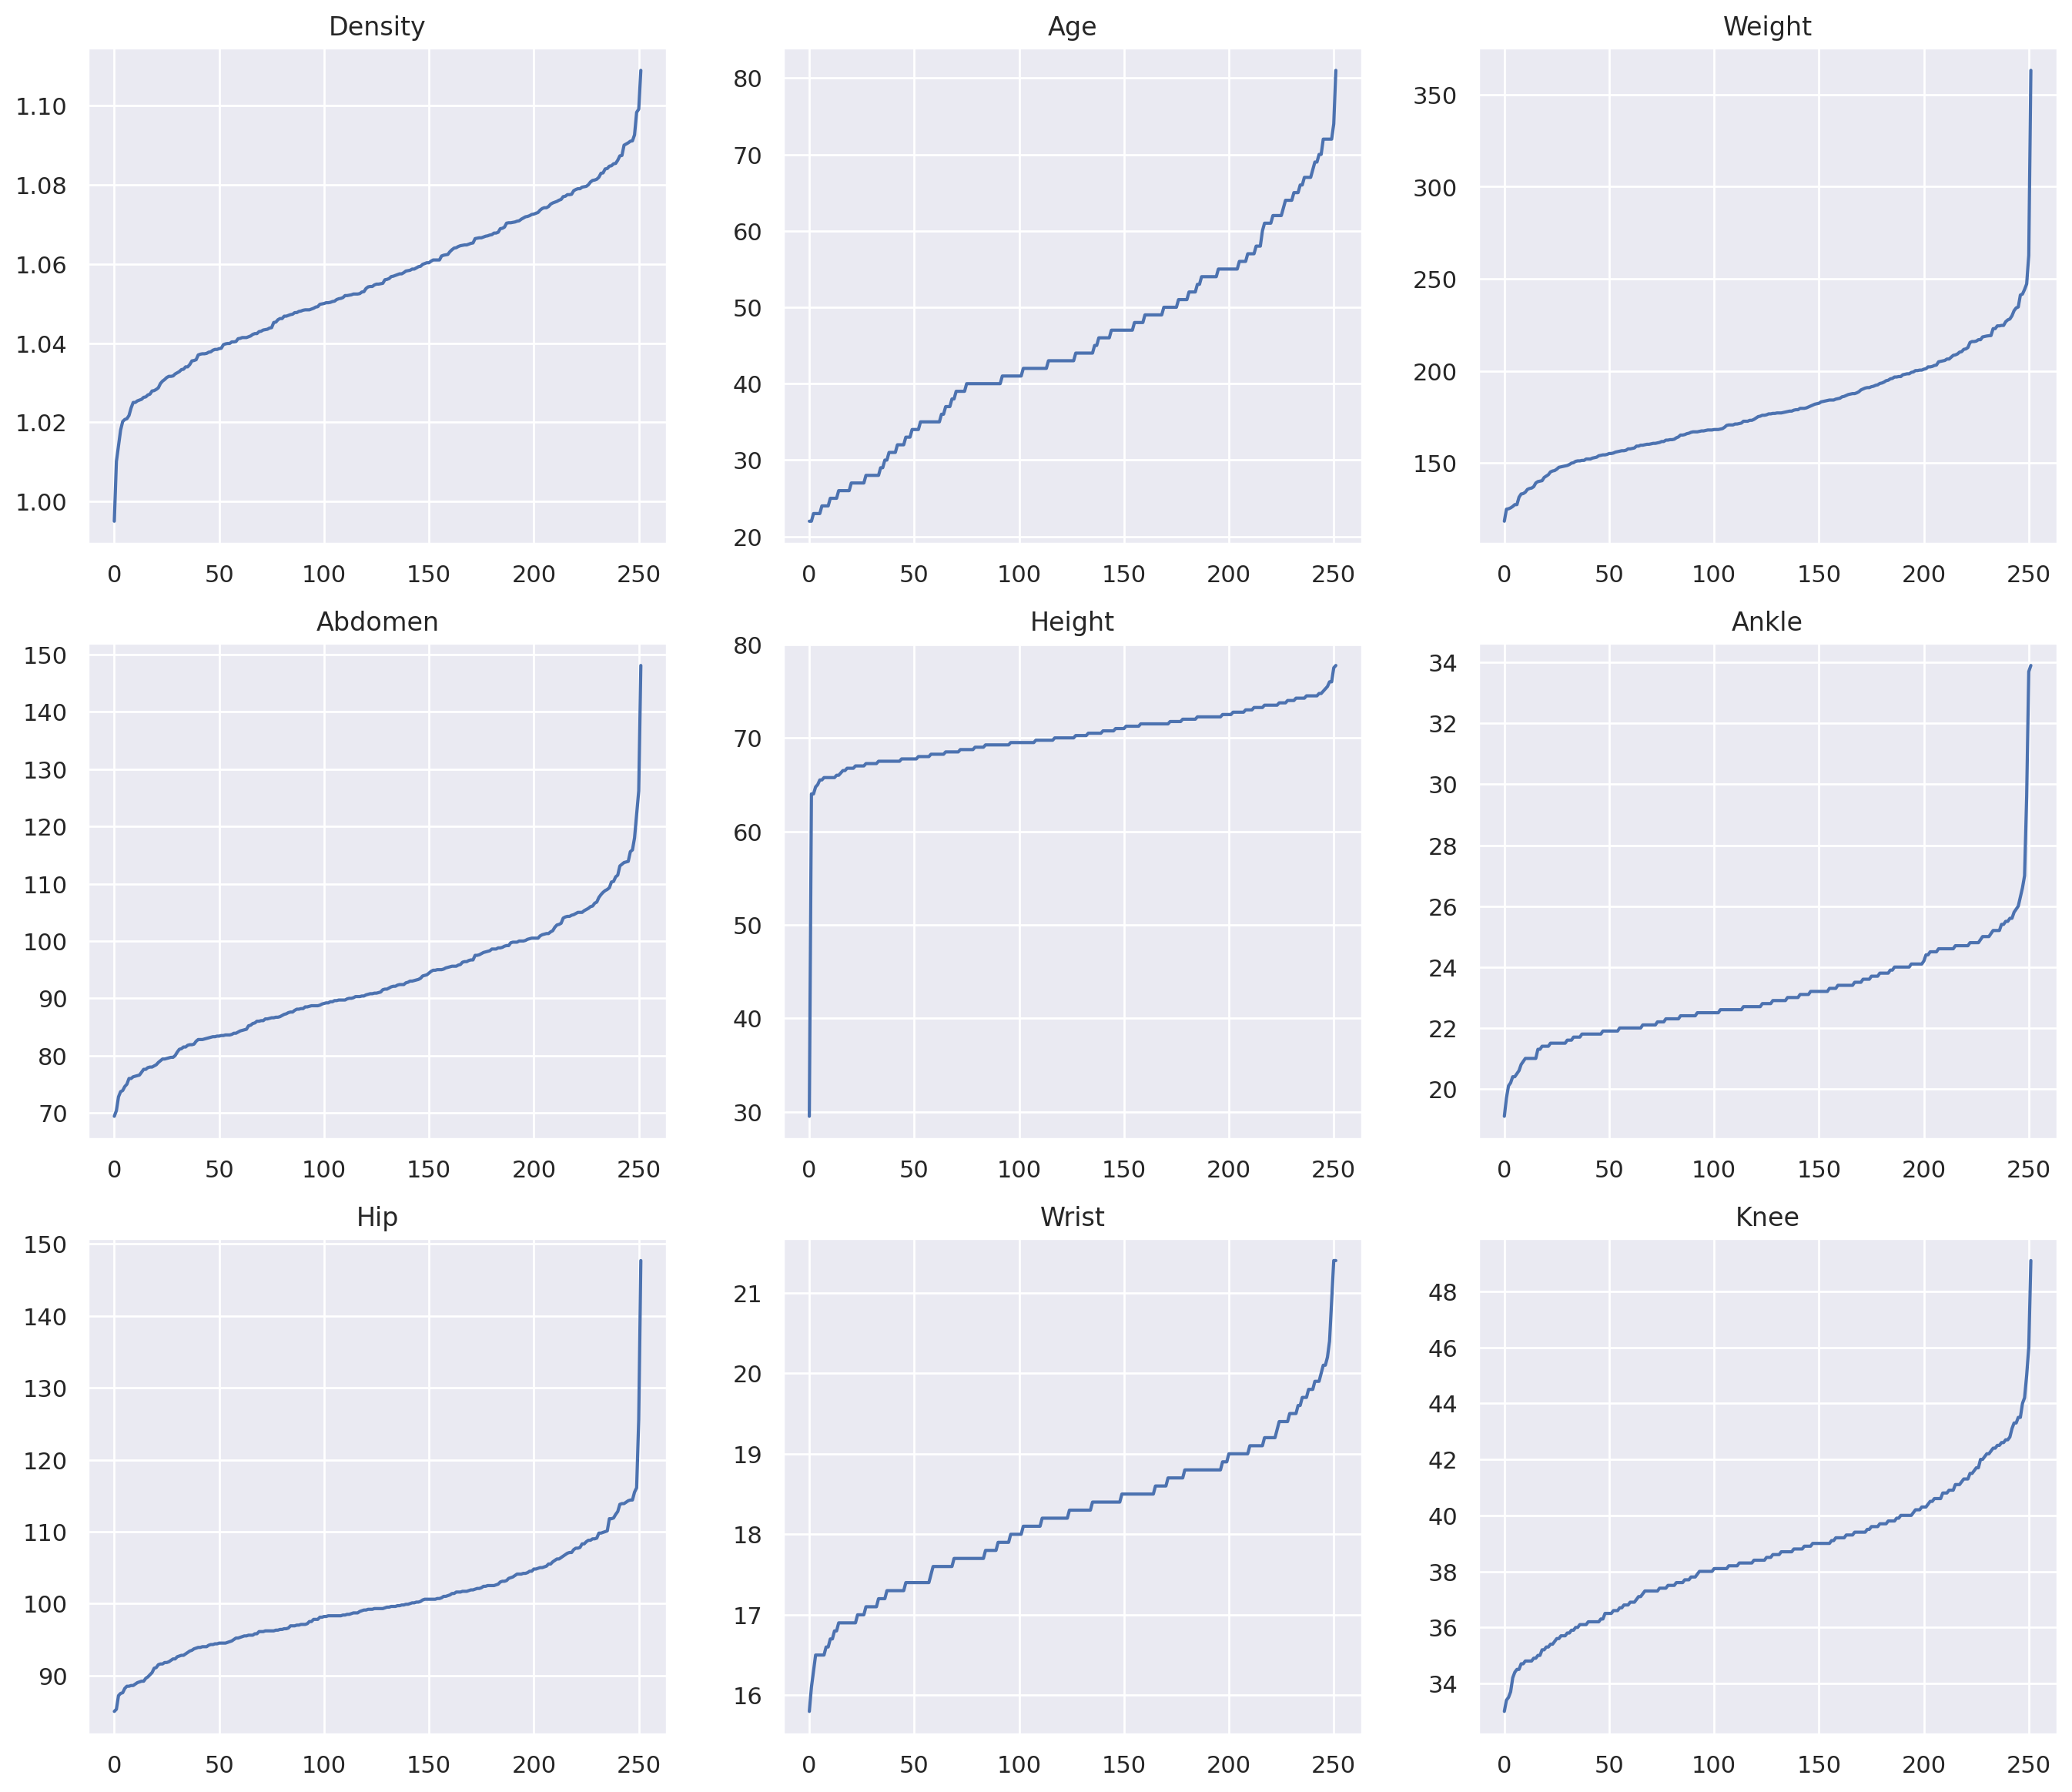

In [92]:
from seaborn import pairplot, scatterplot
import matplotlib.pyplot as plt
density = list(data["Density"])
density.sort()
age = list(data["Age"])
age.sort()
weight = list(data["Weight"])
weight.sort()
abdomen = list(data["Abdomen"])
abdomen.sort()
height = list(data["Height"])
height.sort()
ankle = list(data["Ankle"])
ankle.sort()
hip = list(data["Hip"])
hip.sort()
wrist = list(data["Wrist"])
wrist.sort()
knee = list(data["Knee"])
knee.sort()
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3)
arr = [ax0, ax1, ax2, ax3]
ax0.plot(density)
ax0.set_title("Density")
ax1.plot(age)
ax1.set_title("Age")
ax2.plot(weight)
ax2.set_title("Weight")
ax3.plot(abdomen)
ax3.set_title("Abdomen")
ax4.plot(height)
ax4.set_title("Height")
ax5.plot(ankle)
ax5.set_title("Ankle")
ax6.plot(hip)
ax6.set_title("Hip")
ax7.plot(wrist)
ax7.set_title("Wrist")
ax8.plot(knee)
ax8.set_title("Knee")
fig.set_dpi(200)
fig.set_size_inches(16.5, 14.5)

### 3. Inserting missing values
##### - The data is lacking missing values so we artifically insert NaNs to test out the different missing value management methods
##### - We will exclude the BodyFat variable, as this is the predicted variable
##### - The % of values to be inserted and which ones to replace is decided randomly
###### % is within normally distributed with 10 as the mean and 5 as standard deviation, resample until nonnegative value is drawn

In [93]:
from numpy.random import normal
import random
feature_names = list(data.columns)
feature_names.remove("BodyFat")

data_size = len(data["Density"])

for feature in feature_names:
    # sample from normal distribution with mean 10 and stdev 5
    percentage = int(normal(10, 5, 1)[0])
    # if the sampled value was smaller than 0, resample
    while percentage < 0:
        percentage = normal(10, 5, 1)[0]
    # specify the number of missing values to insert
    n_missing_values = int(data_size*percentage/100)
    # randomly select the positions at which the missing values are inserted
    positions = random.sample(range(0, data_size), n_missing_values)
    column = list(data[feature])
    for position in positions:
        column[position] = None
    data[feature] = column

#### Display how many NaN values have been generated

In [94]:
data.isna().sum() 

Density    30
BodyFat     0
Age        32
Weight     30
Height      2
Neck        2
Chest      50
Abdomen    20
Hip        27
Thigh      17
Knee       17
Ankle      17
Biceps     27
Forearm    20
Wrist      30
dtype: int64

In [95]:
# define a function to replace the target column in a row with regressor prediction
def replace_NAN_by_prediction(regressor, row, target_col):
    if math.isnan(row[target_col]):
        return regressor.predict([row.drop(target_col)])[0]
    else:
        return row[target_col]

In [96]:
from seaborn import histplot
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import math 
import matplotlib.pyplot as plt
output_data = pd.DataFrame()
def replace_and_plot(data_new, target_column):
    """
    Returns the new column with the replaced missing values and plots the histograms of the 4 approaches
    """
    # save the new data into a dataframe for histogram plotting
    df = pd.DataFrame(data_new[target_column])

    # create a copy of the data to avoid modifying the original
    train_data = pd.DataFrame(data_new.copy())
    feature_columns = list(train_data.columns)
    feature_columns.remove(target_column)

    # temporarily replace all missing values with their mean for the training process
    for column in train_data.columns:
        if column != target_column:
            train_data[column] = train_data[column].replace(to_replace=np.nan, value=train_data[column].mean(),inplace=False)

    # select those rows where the target value isnt missing to train the model
    train = train_data[train_data[target_column].notna()]

    # train a KNN regressor
    KNN = KNeighborsRegressor().fit(train[feature_columns], train[target_column])
    del train

    df[f"{target_column}_KNN"] = train_data.apply(lambda row: replace_NAN_by_prediction(KNN, row, target_column), axis=1)

    return df[f"{target_column}_KNN"]

In [97]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_bridge = IterativeImputer(estimator=BayesianRidge(), random_state=0)

imputed_mean = pd.DataFrame(imp_mean.fit_transform(data))
imputed_mean.set_axis(d.columns, axis=1, inplace=True)

imputed_BR = pd.DataFrame(imp_bridge.fit_transform(data))
imputed_BR.set_axis(d.columns, axis=1, inplace=True)


In [98]:
def plot_imputations(original, missing, col):
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
    arr = [ax0, ax1, ax2, ax3]
    nan_percentage = data[col].isna().sum() / len(data[col]) * 100
    n_bins=10

    ax0.hist(original[col], n_bins, histtype='bar', color="red", label="Original", alpha=0.4, edgecolor='black')
    ax0.hist(imputed_mean[col], n_bins, histtype='bar', color="blue", label="Mean Imputed", alpha=0.4, edgecolor='black')
    ax0.legend(prop={'size': 9})
    ax0.set_title(f"{col} Missing: {round(nan_percentage)}%")


    ax1.hist(original[col], n_bins, histtype='bar', color="red", label="Original", alpha=0.4, edgecolor='black')
    ax1.hist(replace_and_plot(missing, col), n_bins, histtype='bar', color="blue", label="KNN Imputed", alpha=0.4, edgecolor='black')
    ax1.legend(prop={'size': 9})
    ax1.set_title(f"{col} Missing: {round(nan_percentage)}%")


    ax2.hist(original[col], n_bins, histtype='bar', color="red", label="Original", alpha=0.4, edgecolor='black')
    ax2.hist(imputed_BR[col], n_bins, histtype='bar', color="blue", label="Bayesian Ridge Imputed", alpha=0.4, edgecolor='black')
    ax2.legend(prop={'size': 9})
    ax2.set_title(f"{col} Missing: {round(nan_percentage)}%")

    ax3.hist(original[col], n_bins, histtype='bar', color="red", label="Original", alpha=0.4, edgecolor='black')
    ax3.hist(missing.interpolate()[col], n_bins, histtype='bar', color="blue", label="Interpolation", alpha=0.4, edgecolor='black')
    ax3.legend(prop={'size': 9})
    ax3.set_title(f"{col} Missing: {round(nan_percentage)}%")

    fig.set_dpi(200)
    fig.set_size_inches(16.5, 14.5)
    
    return imputed_BR[col]

In [99]:
# create a copy of the data with missing values for future comparison
data_new = data.copy()

### 4. Fixing missing values
#### The approaches tested will be replacing missing values with:
##### - Mean
##### - Multivariate Imputation 
##### - KNN regression
##### - Interpolation

The new replaced values can be assigned using 
```
data[column_name] = replace_and_plot(data, column_name)
```

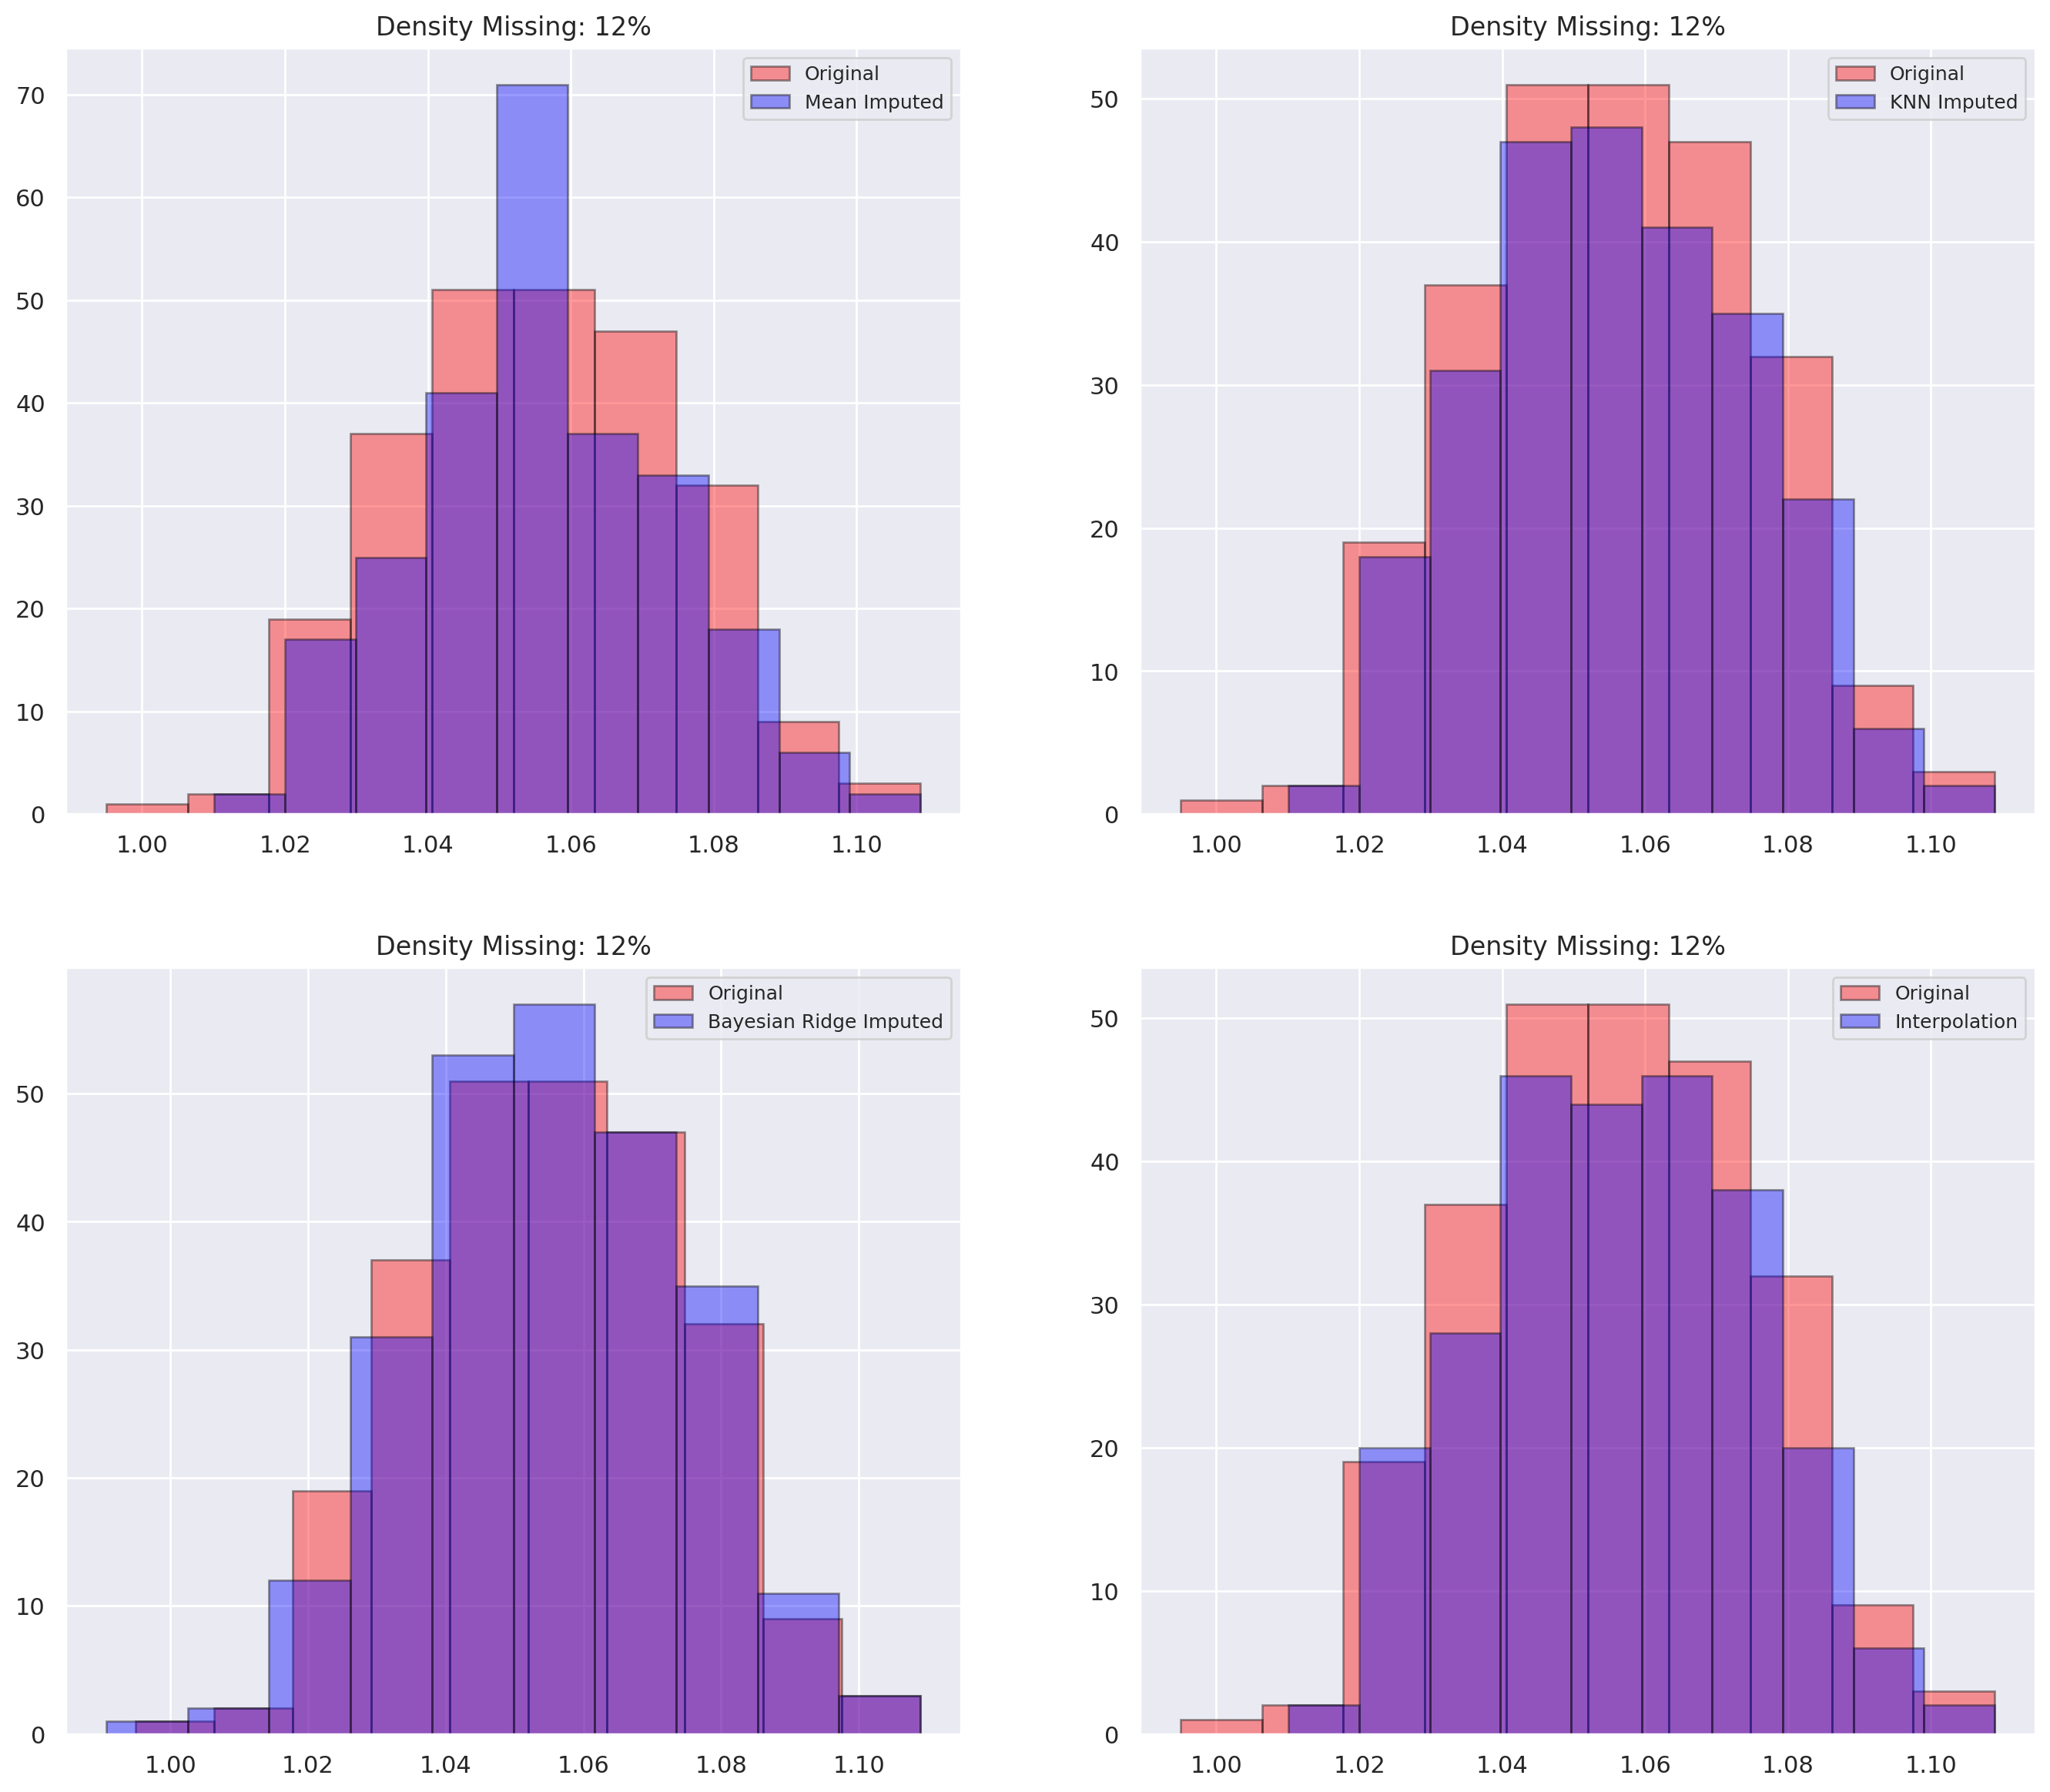

In [100]:
import warnings
warnings.filterwarnings('ignore')

output_data["Density"] = plot_imputations(d, data, "Density")

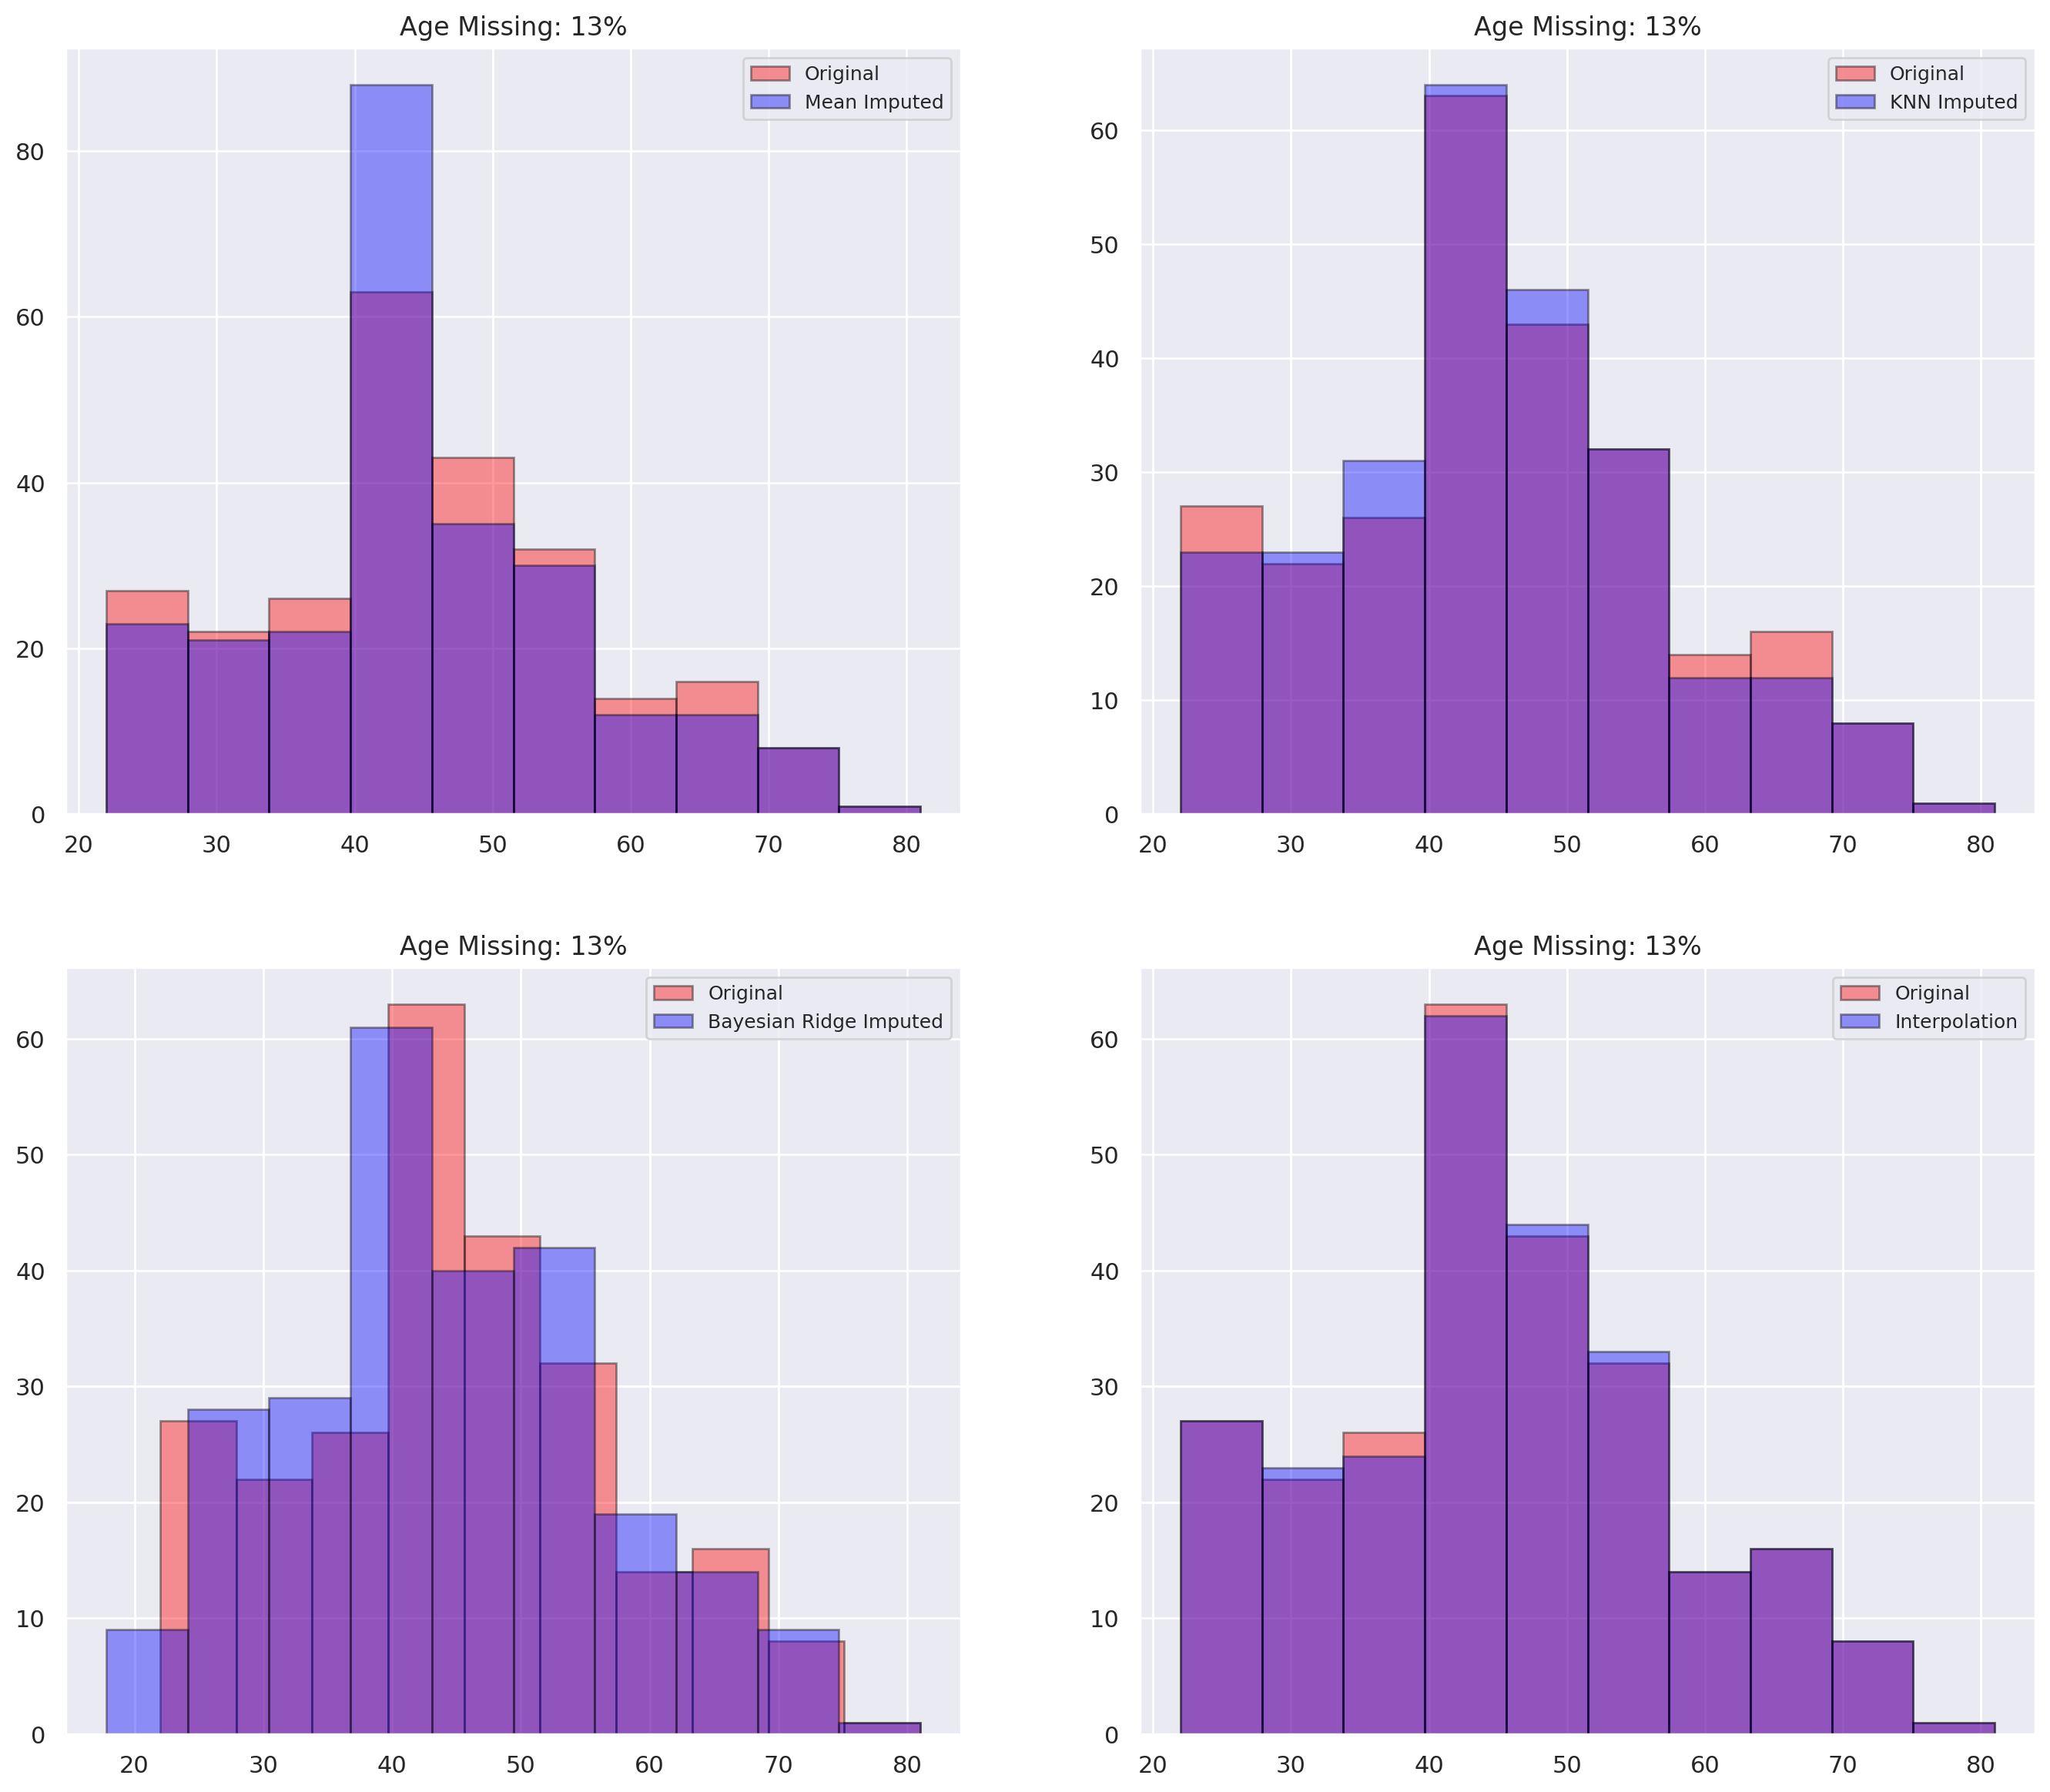

In [101]:
output_data["Age"] = plot_imputations(d, data, "Age")

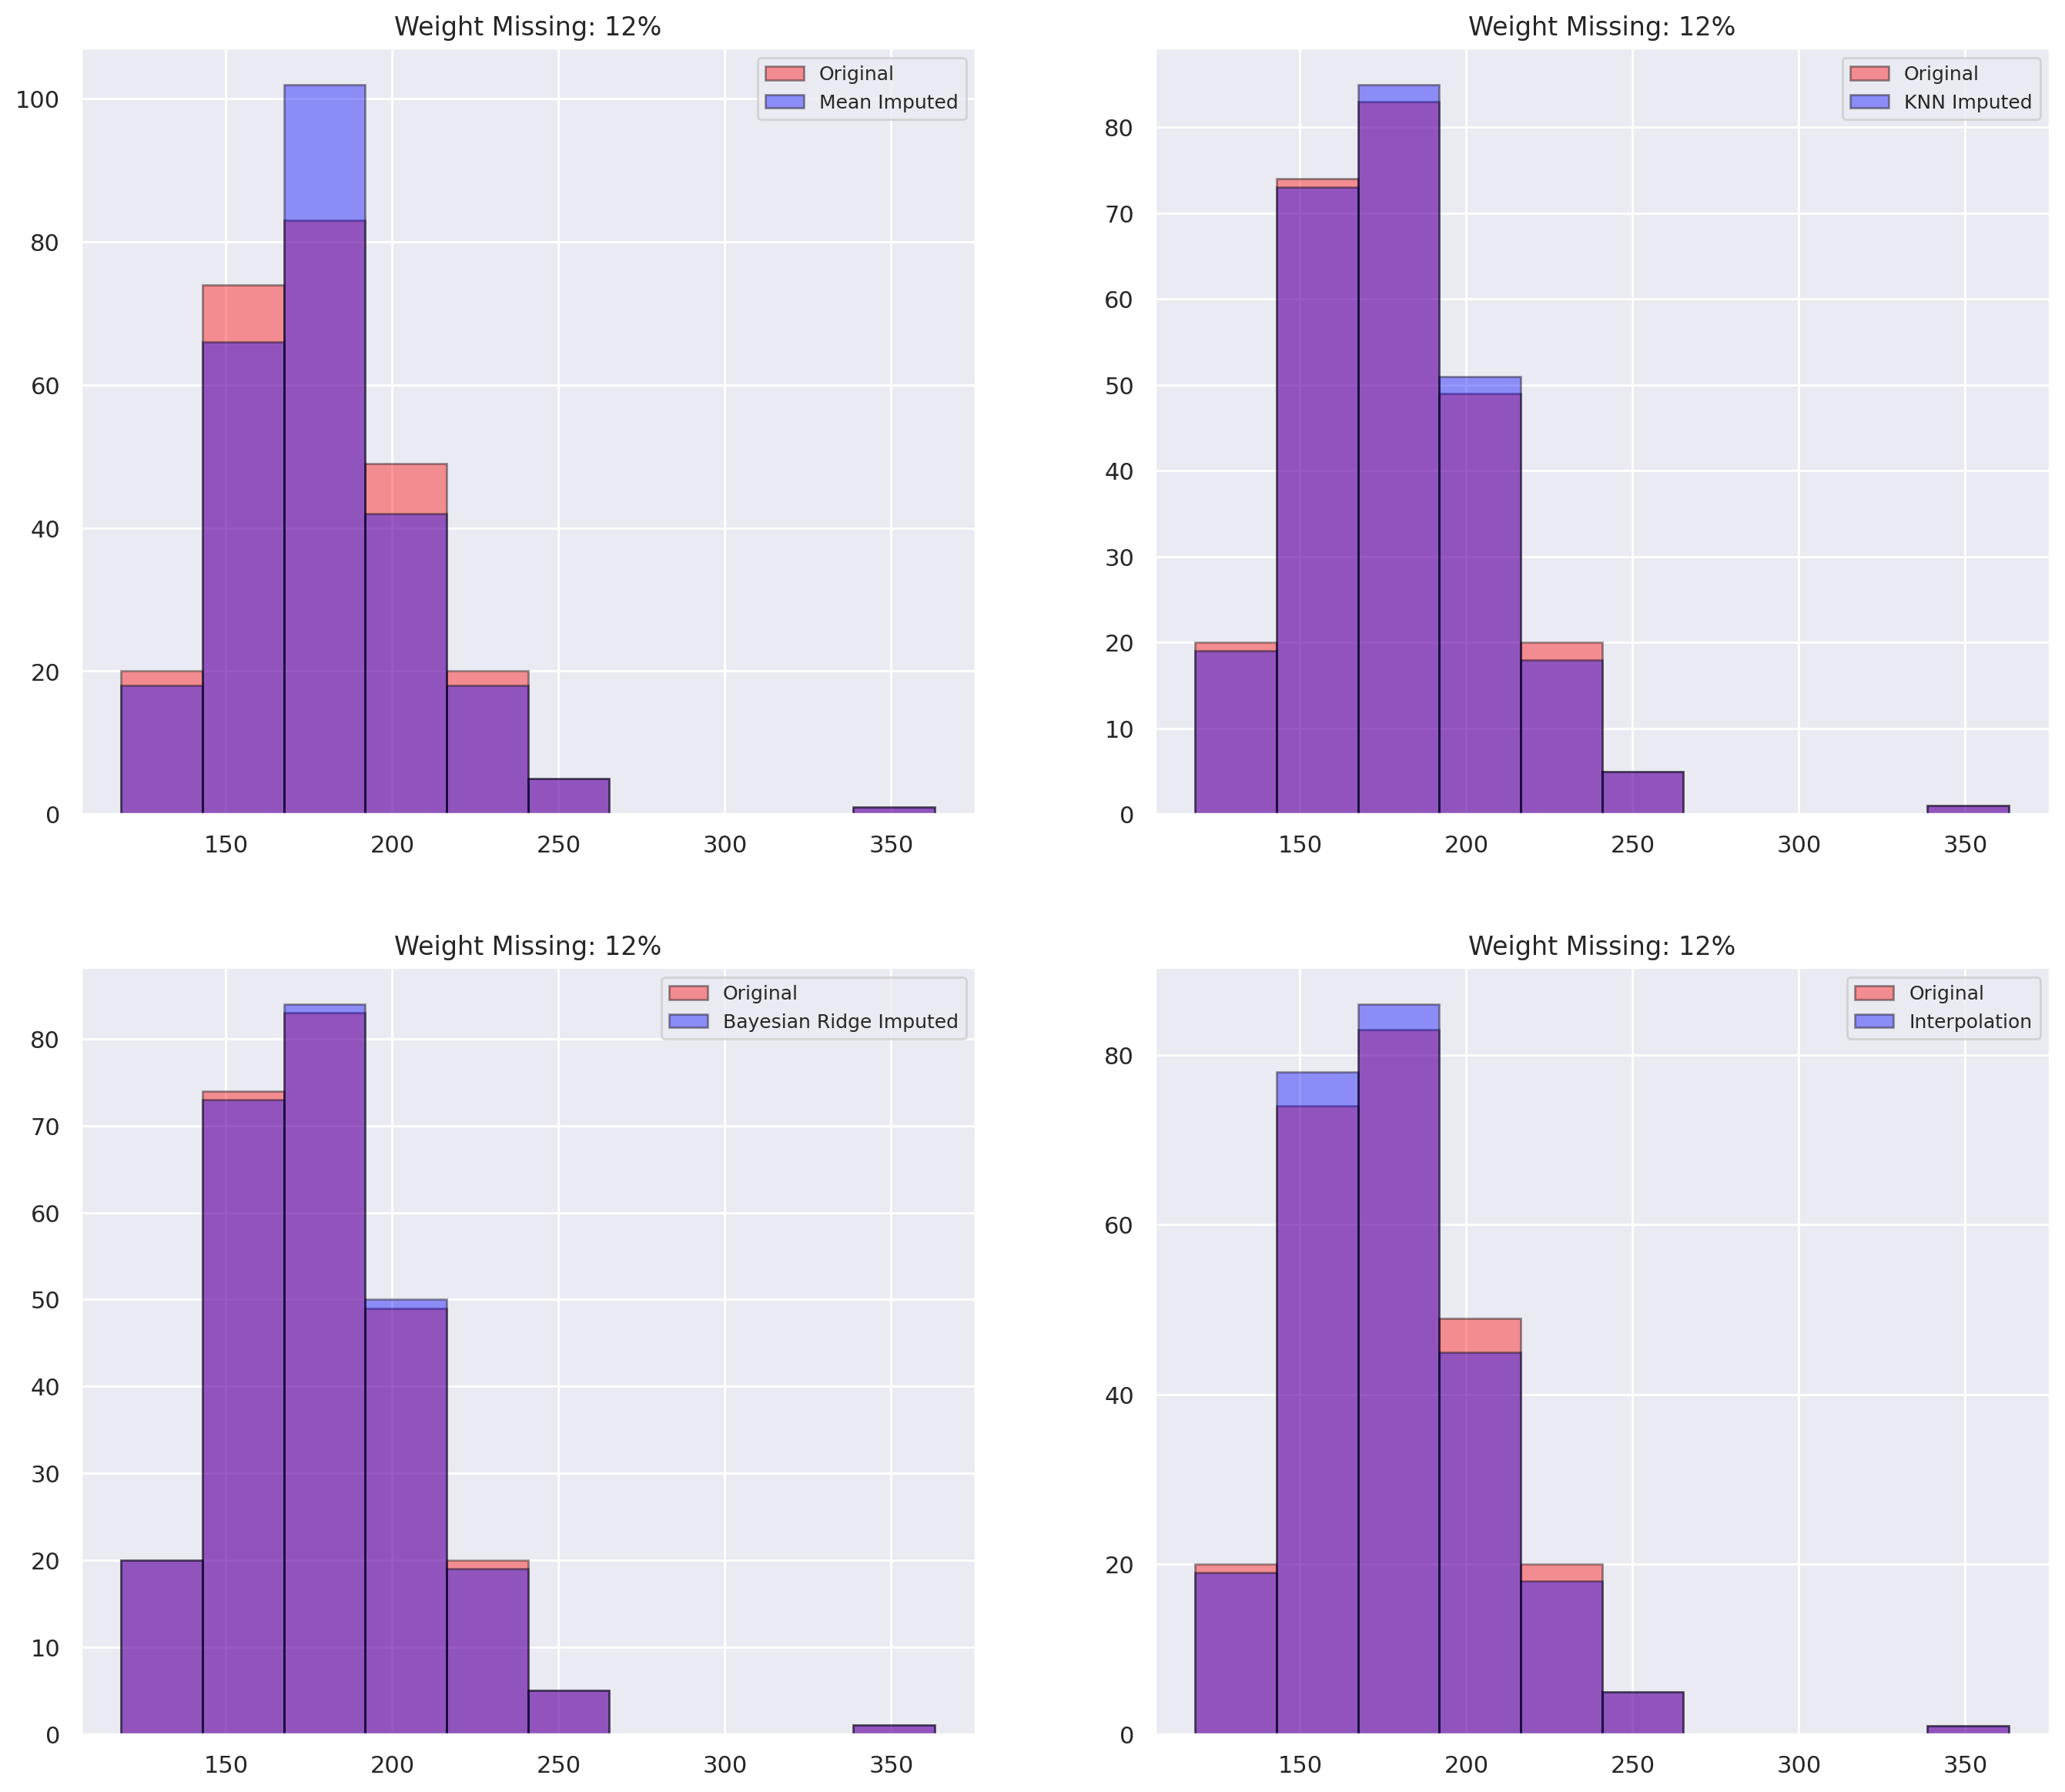

In [102]:
output_data["Weight"] = plot_imputations(d, data, "Weight")

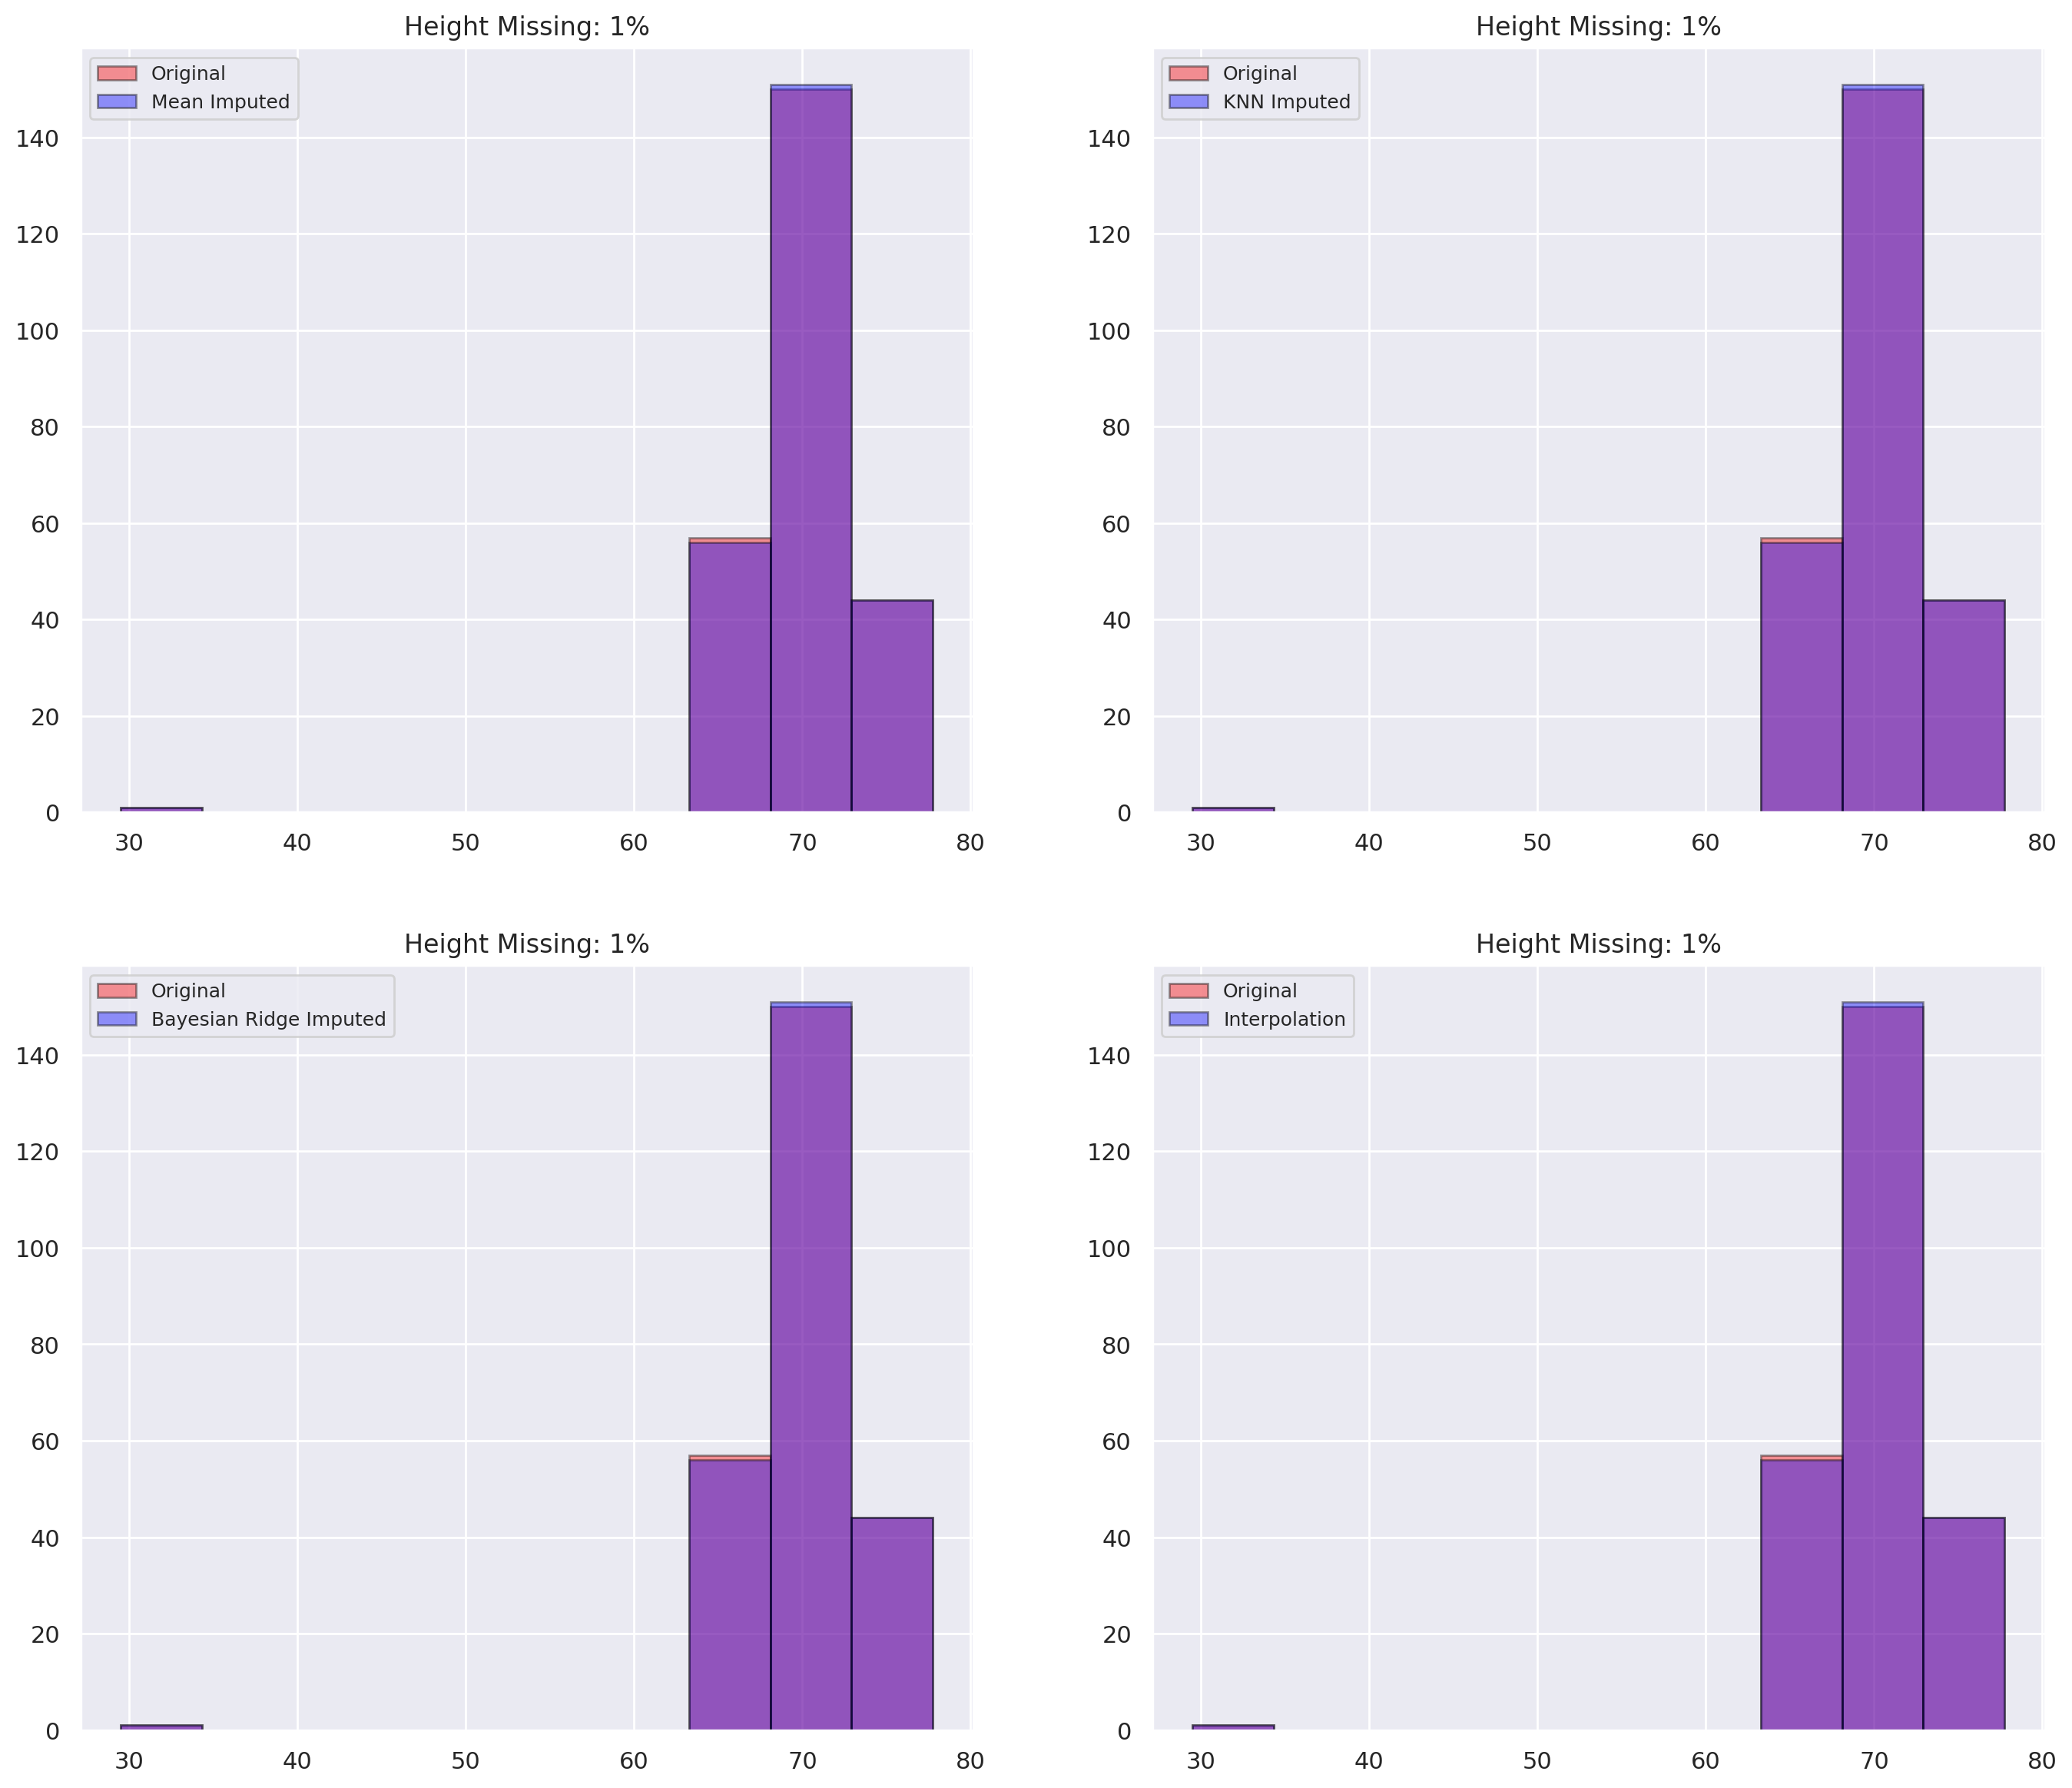

In [103]:
output_data["Height"] = plot_imputations(d, data, "Height")

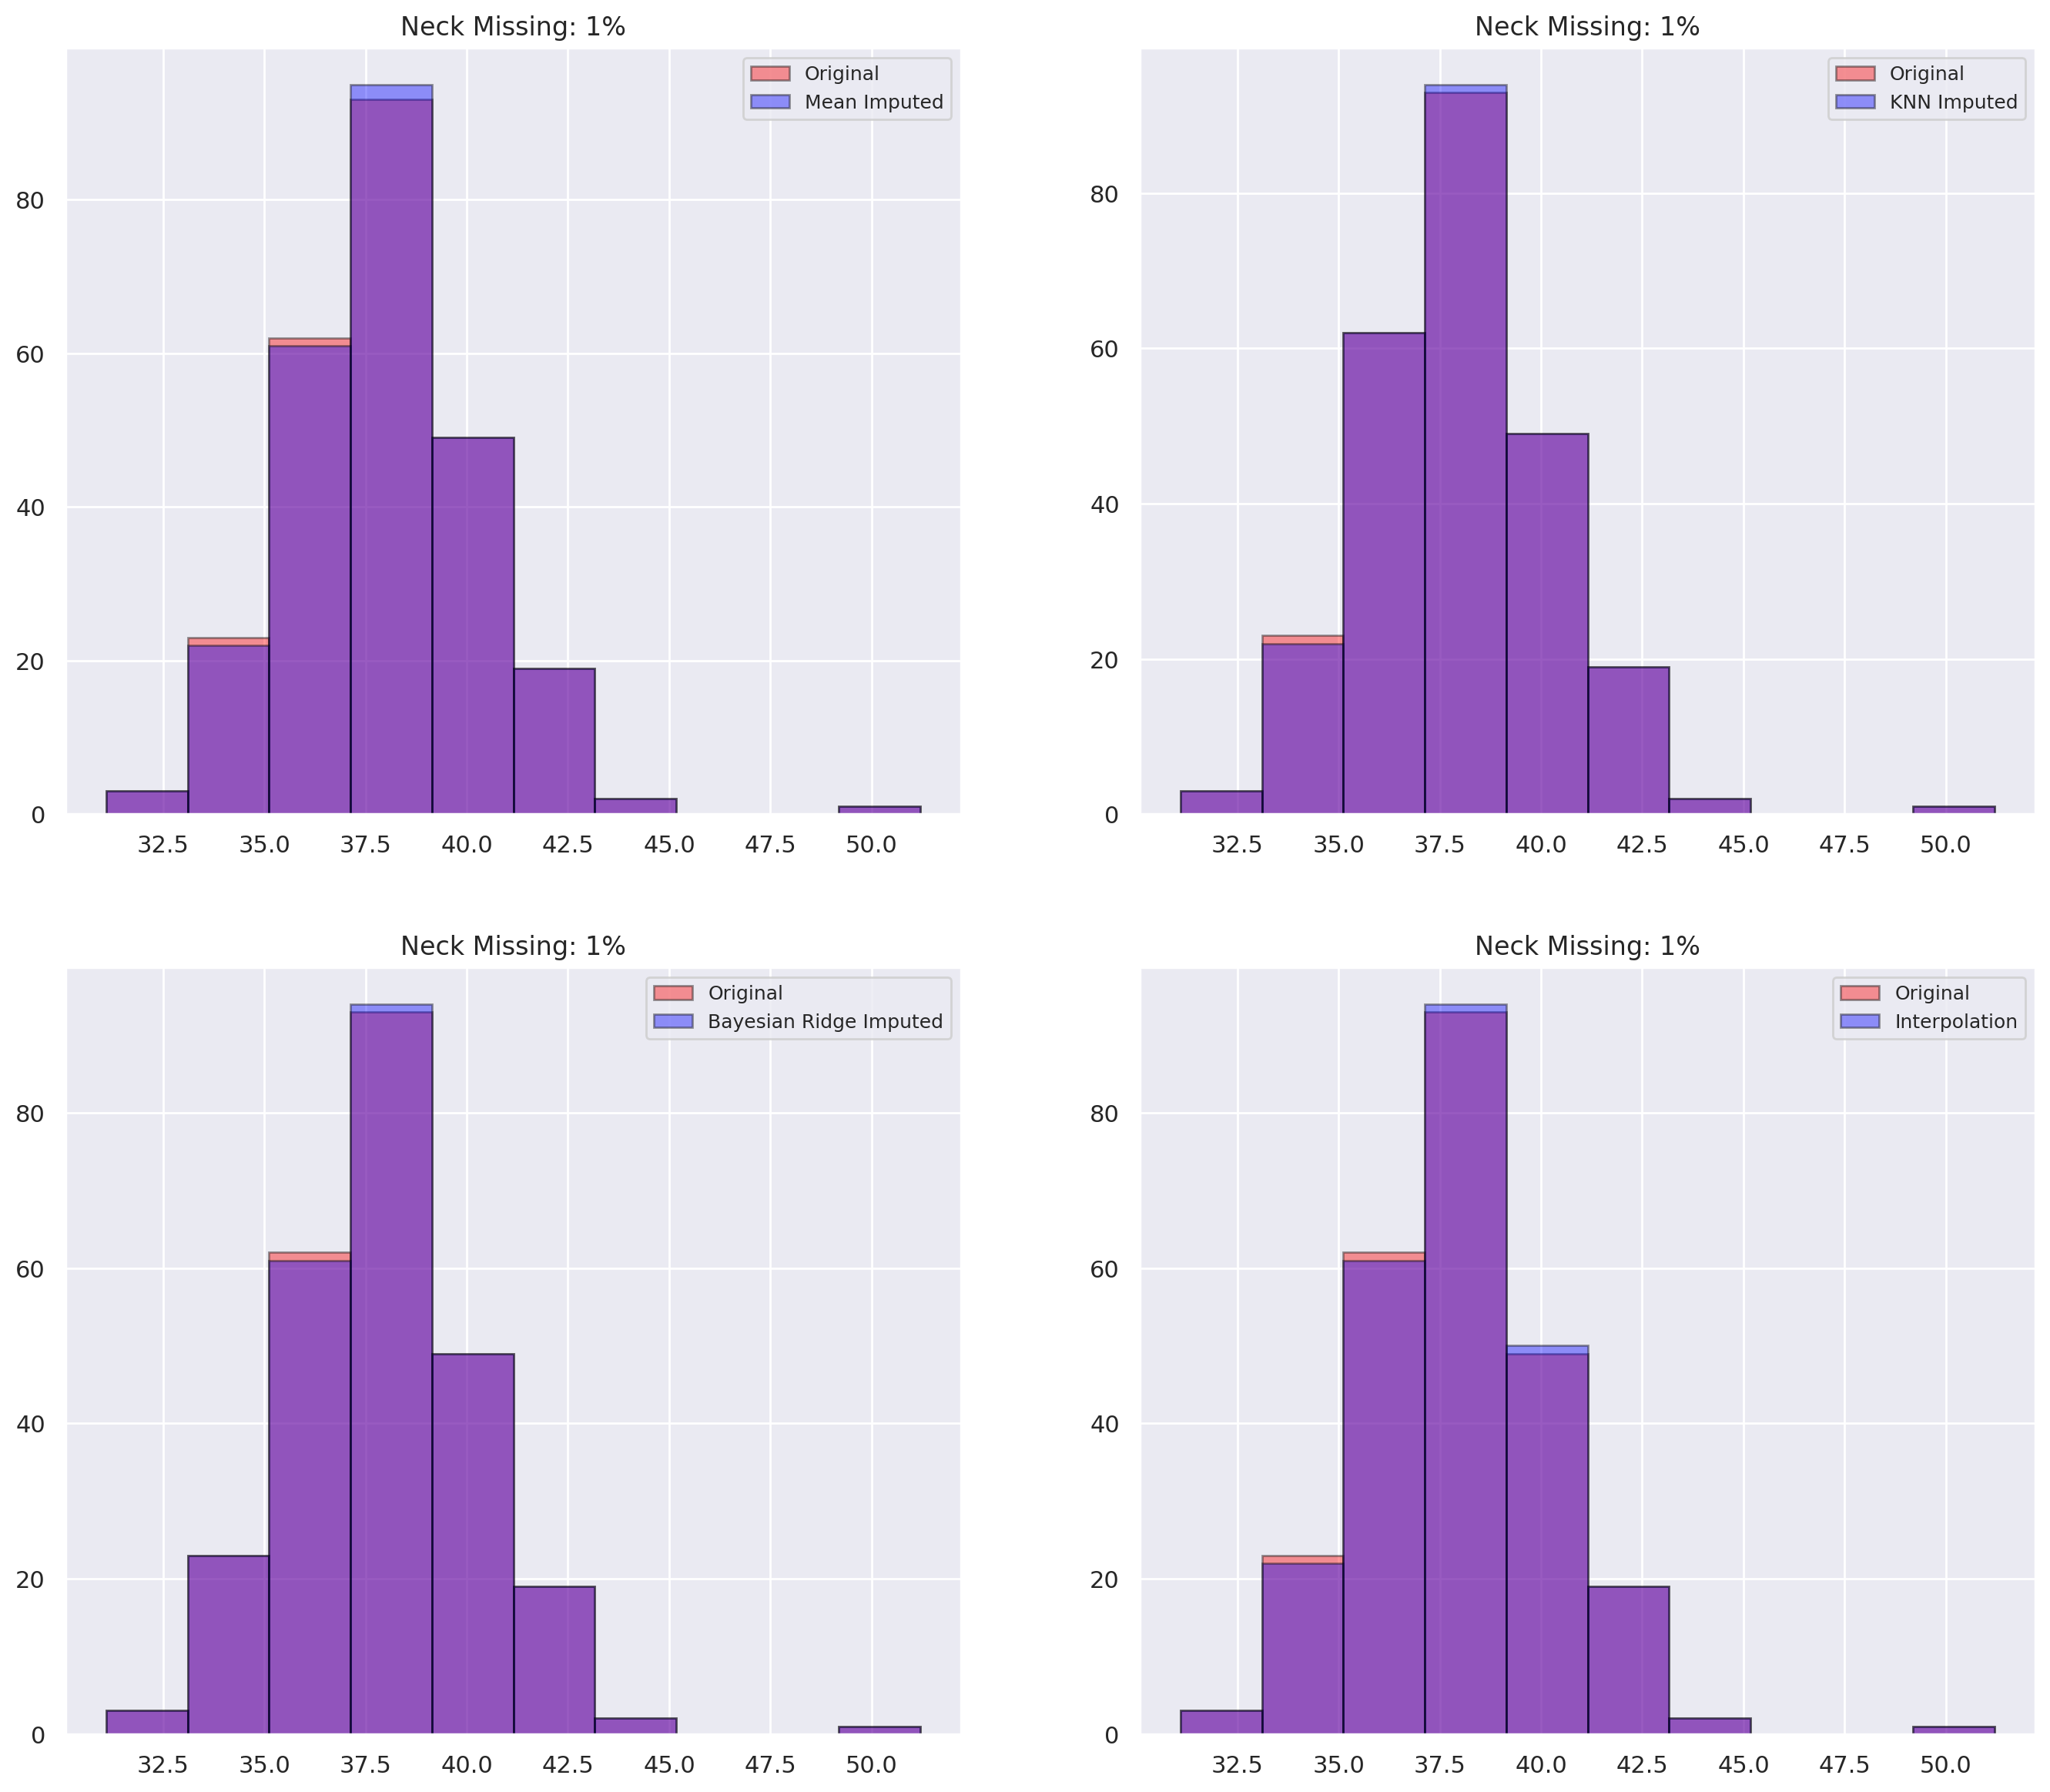

In [104]:
output_data["Neck"] = plot_imputations(d, data, "Neck")

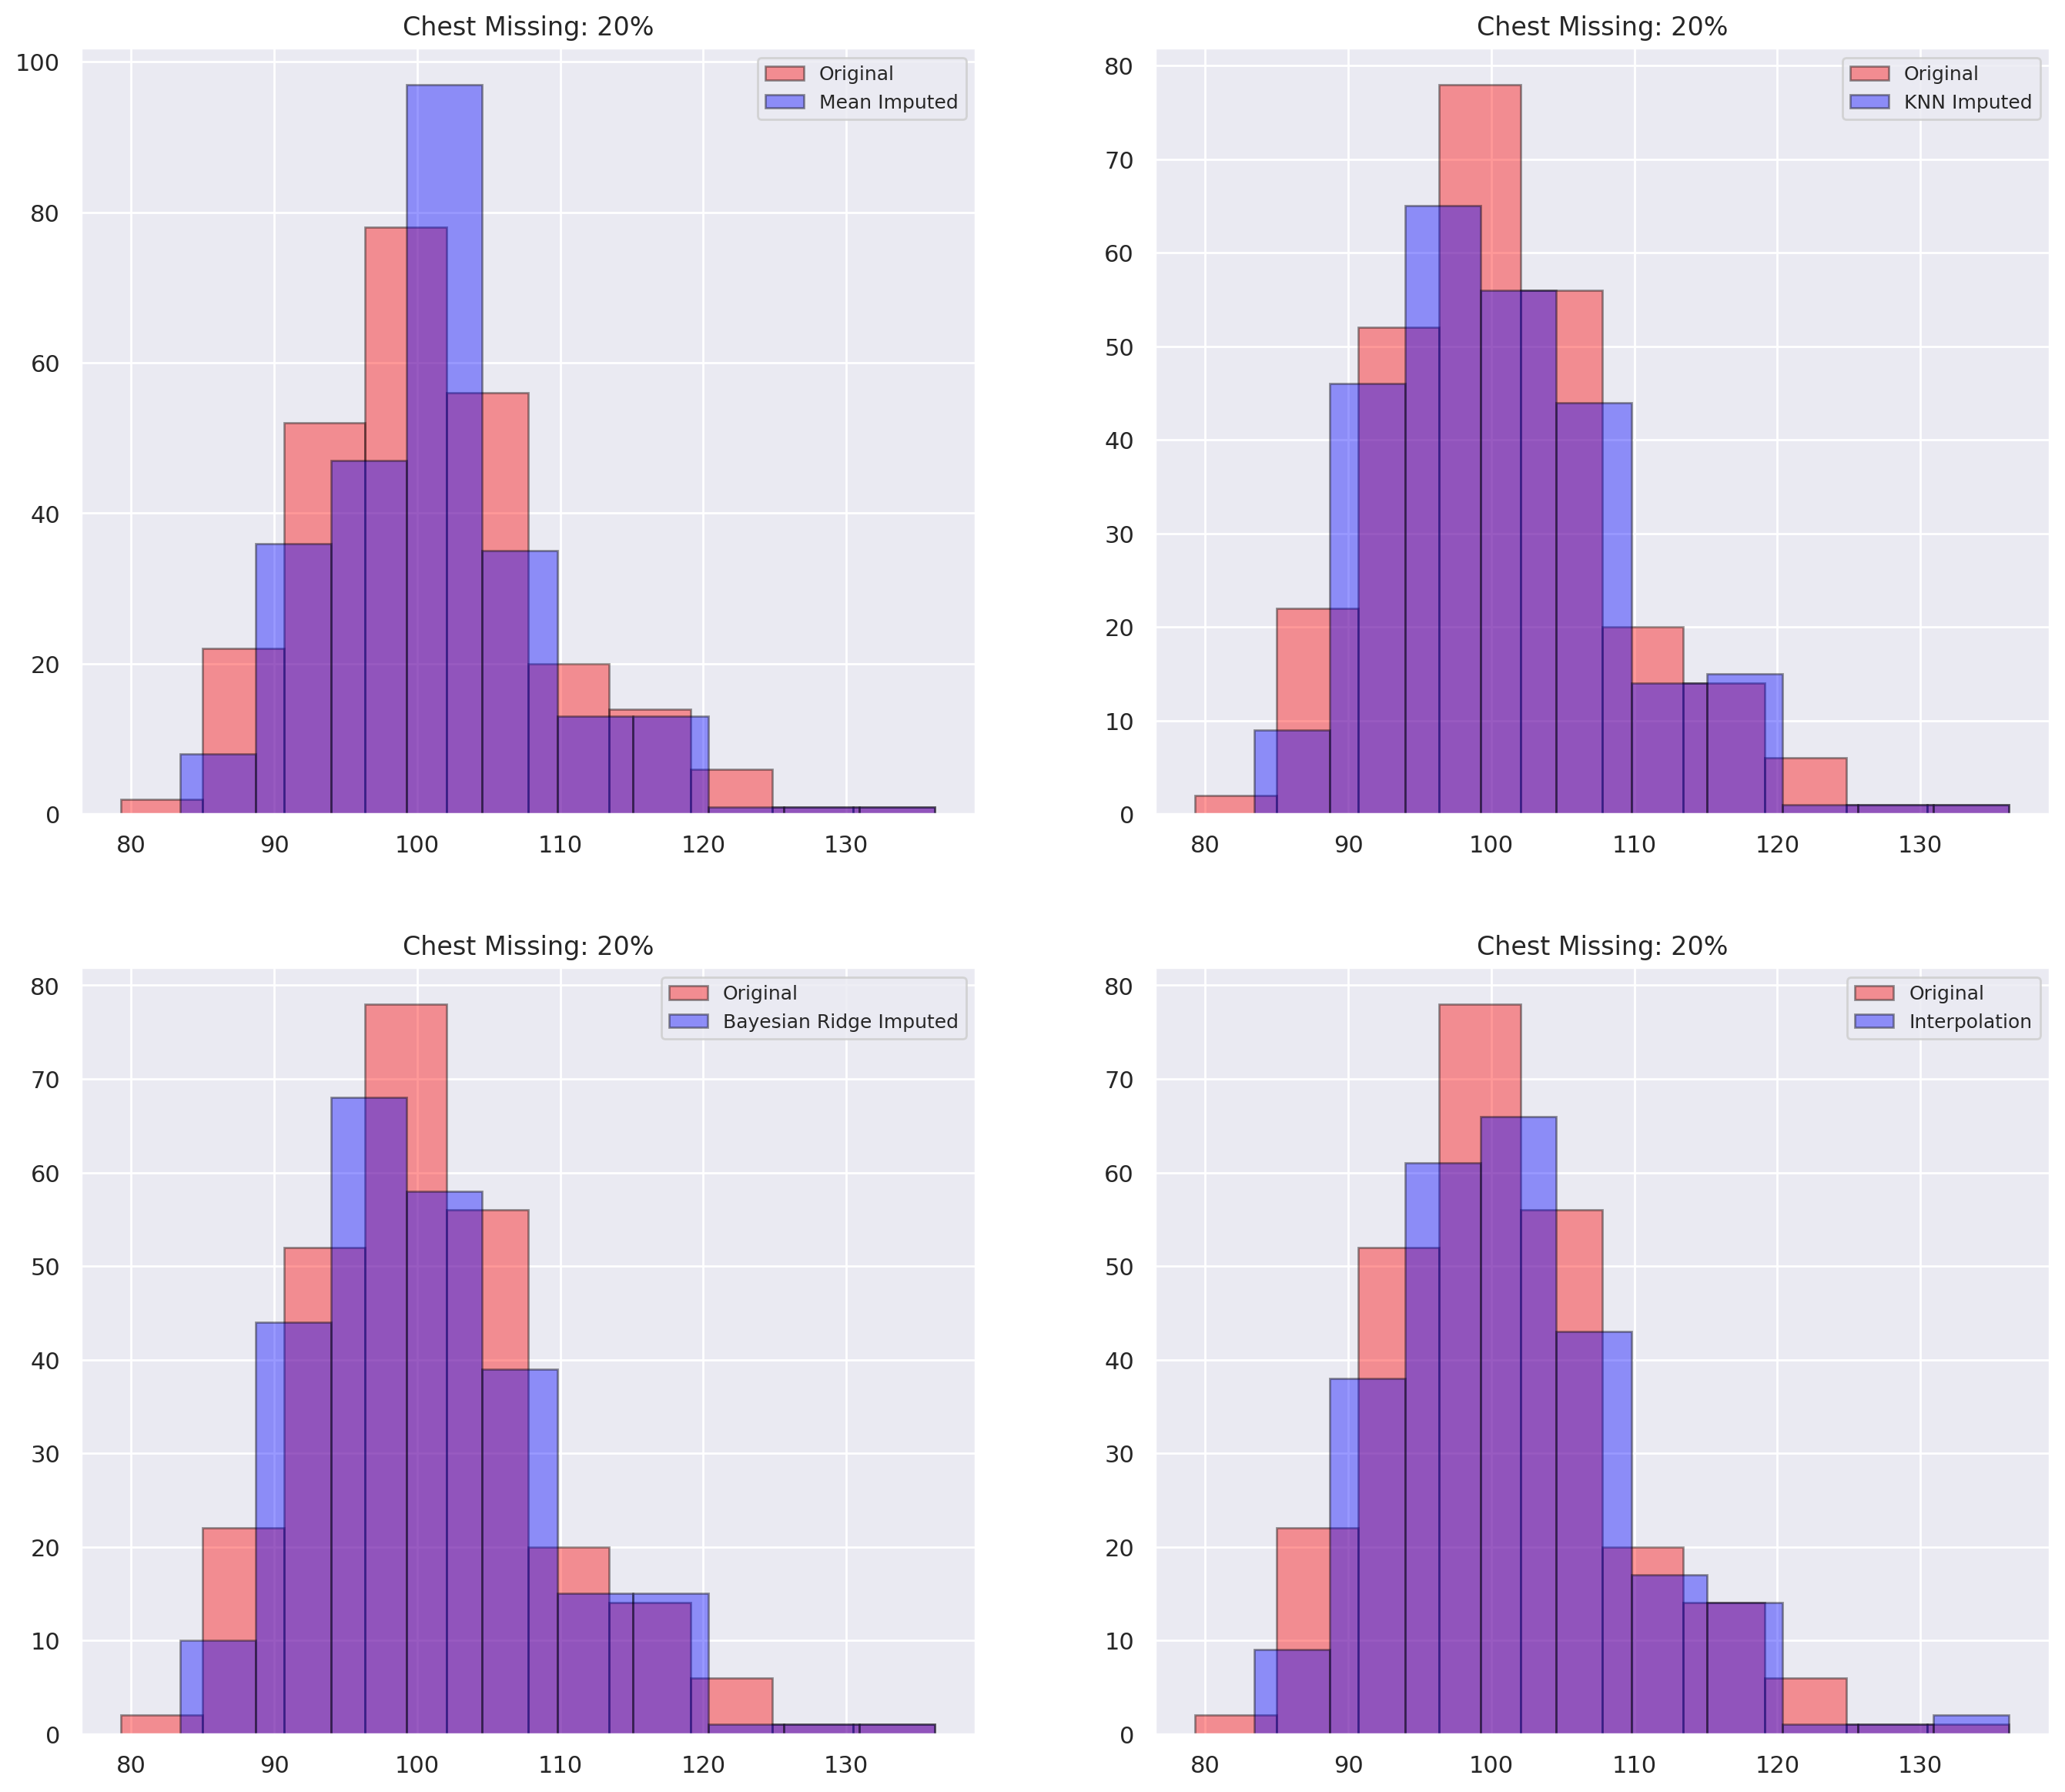

In [105]:
output_data["Chest"] = plot_imputations(d, data, "Chest")

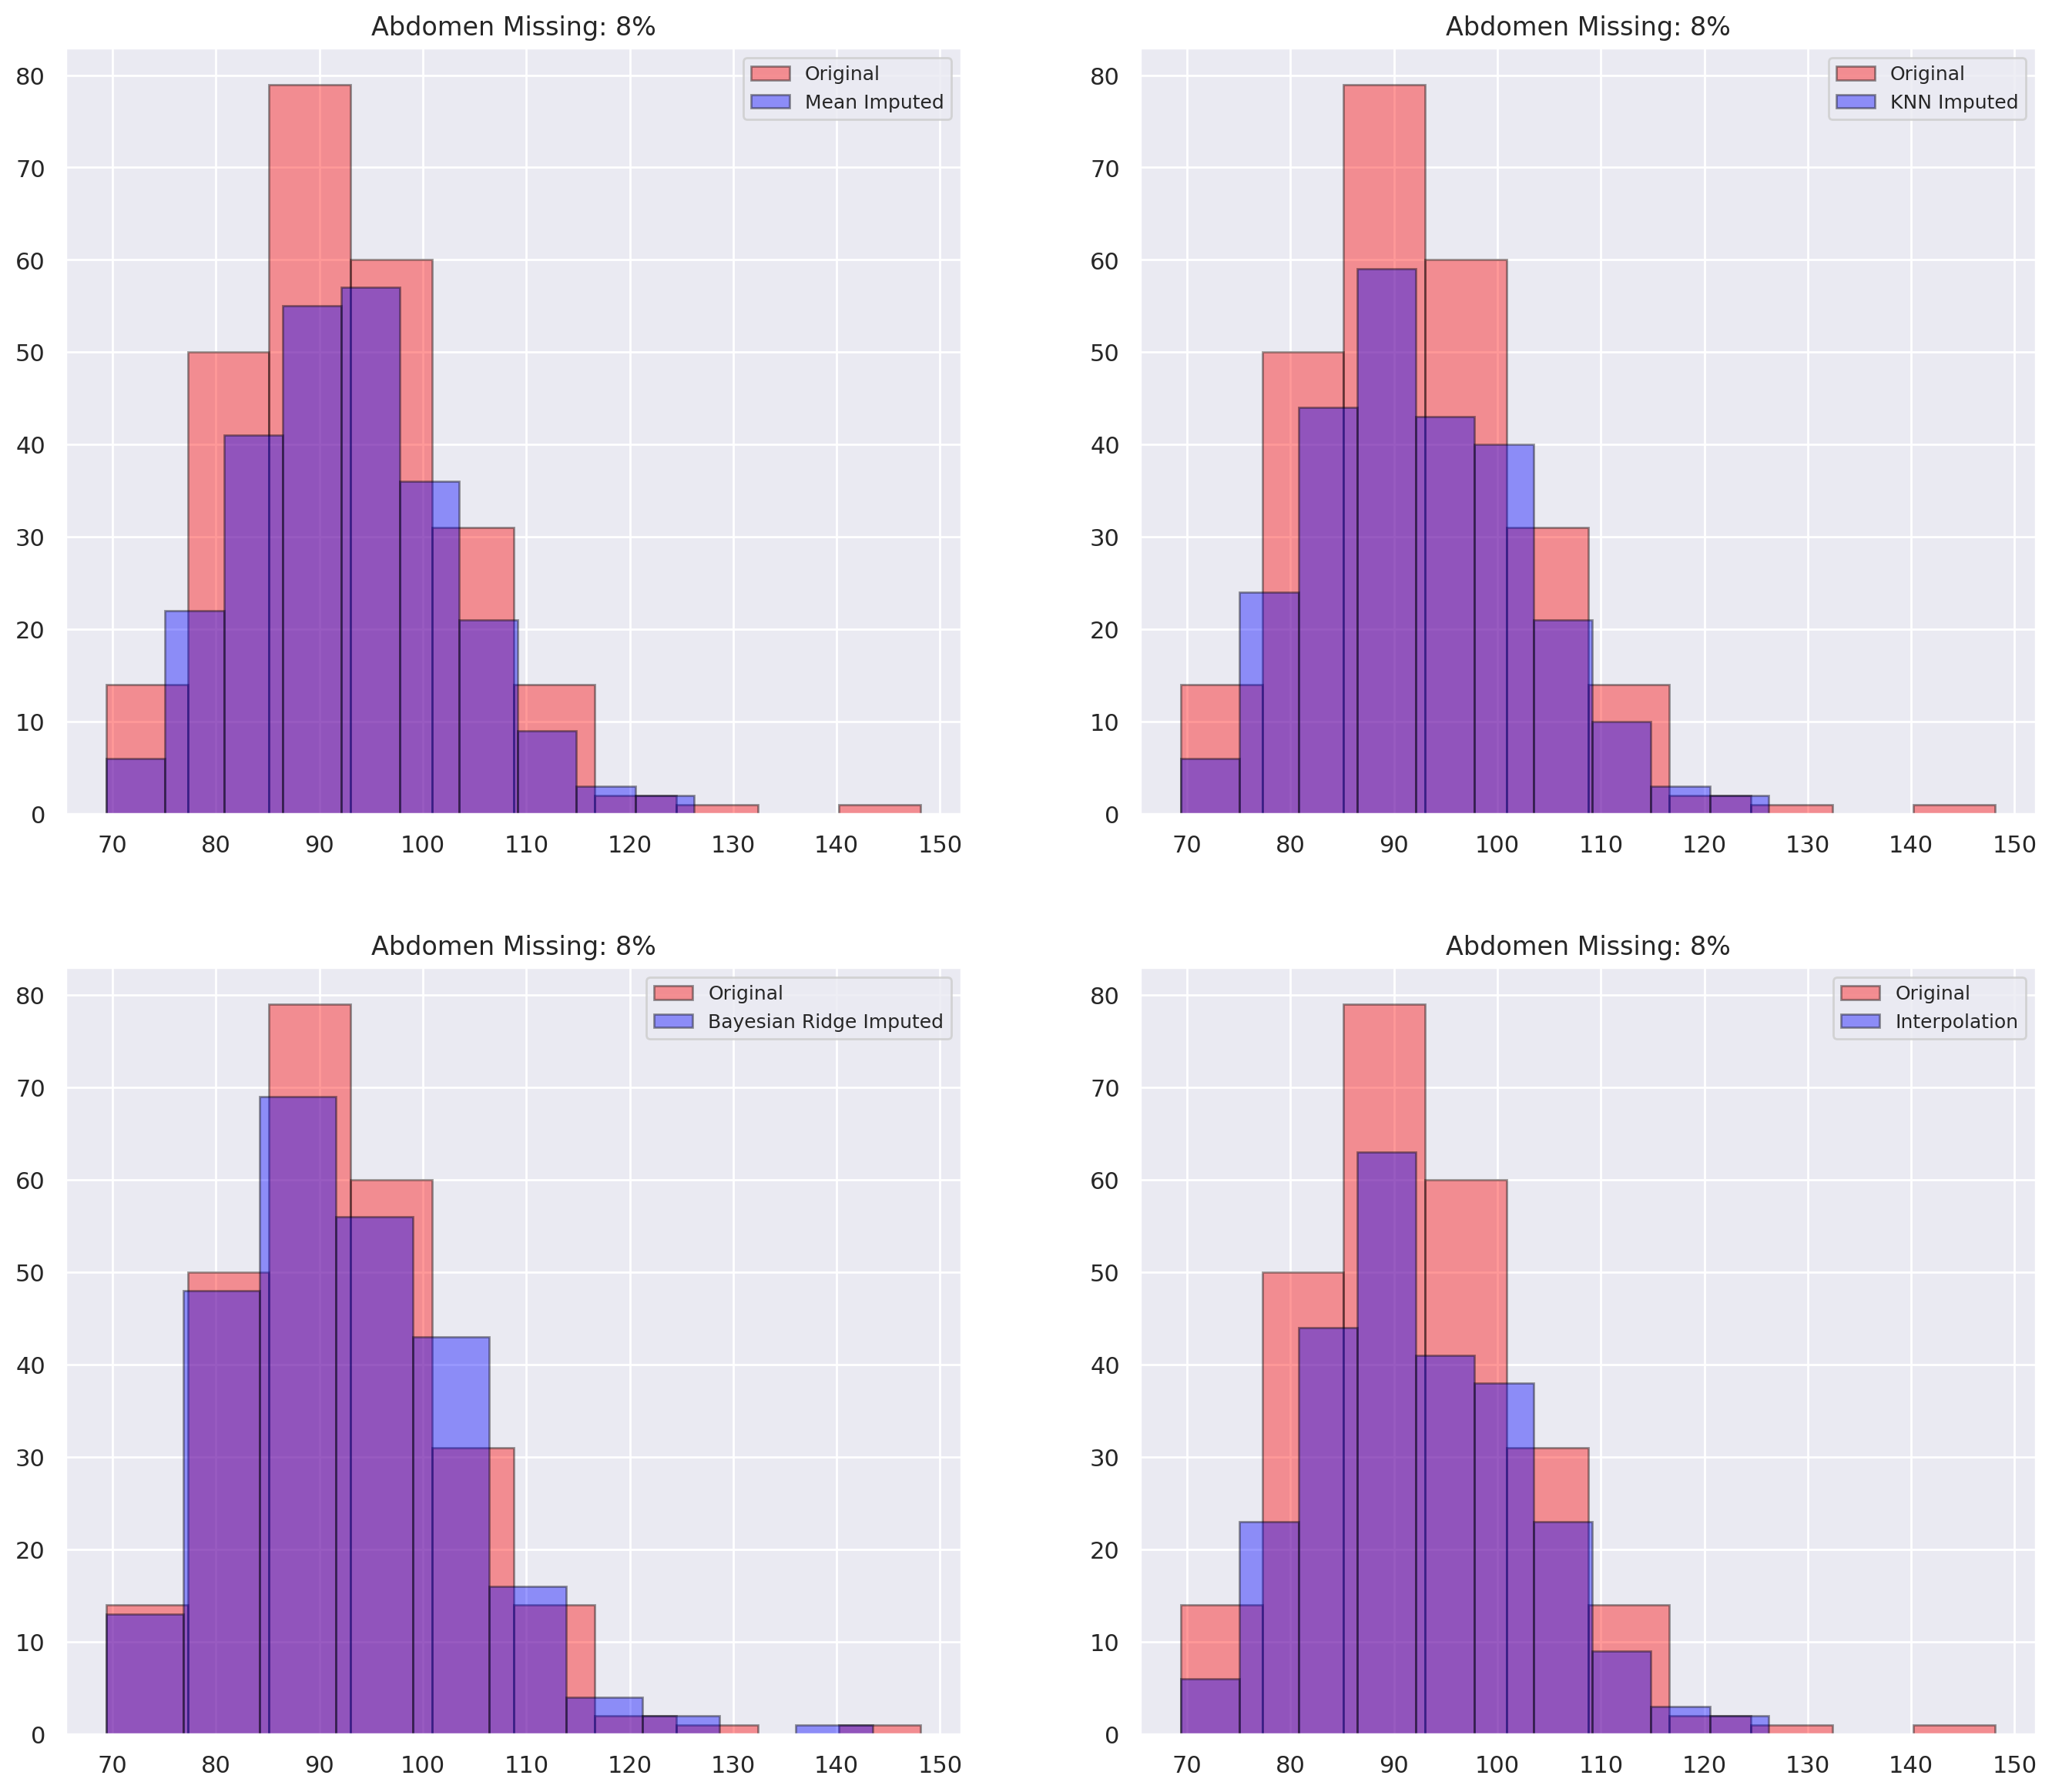

In [106]:
output_data["Abdomen"] = plot_imputations(d, data, "Abdomen")

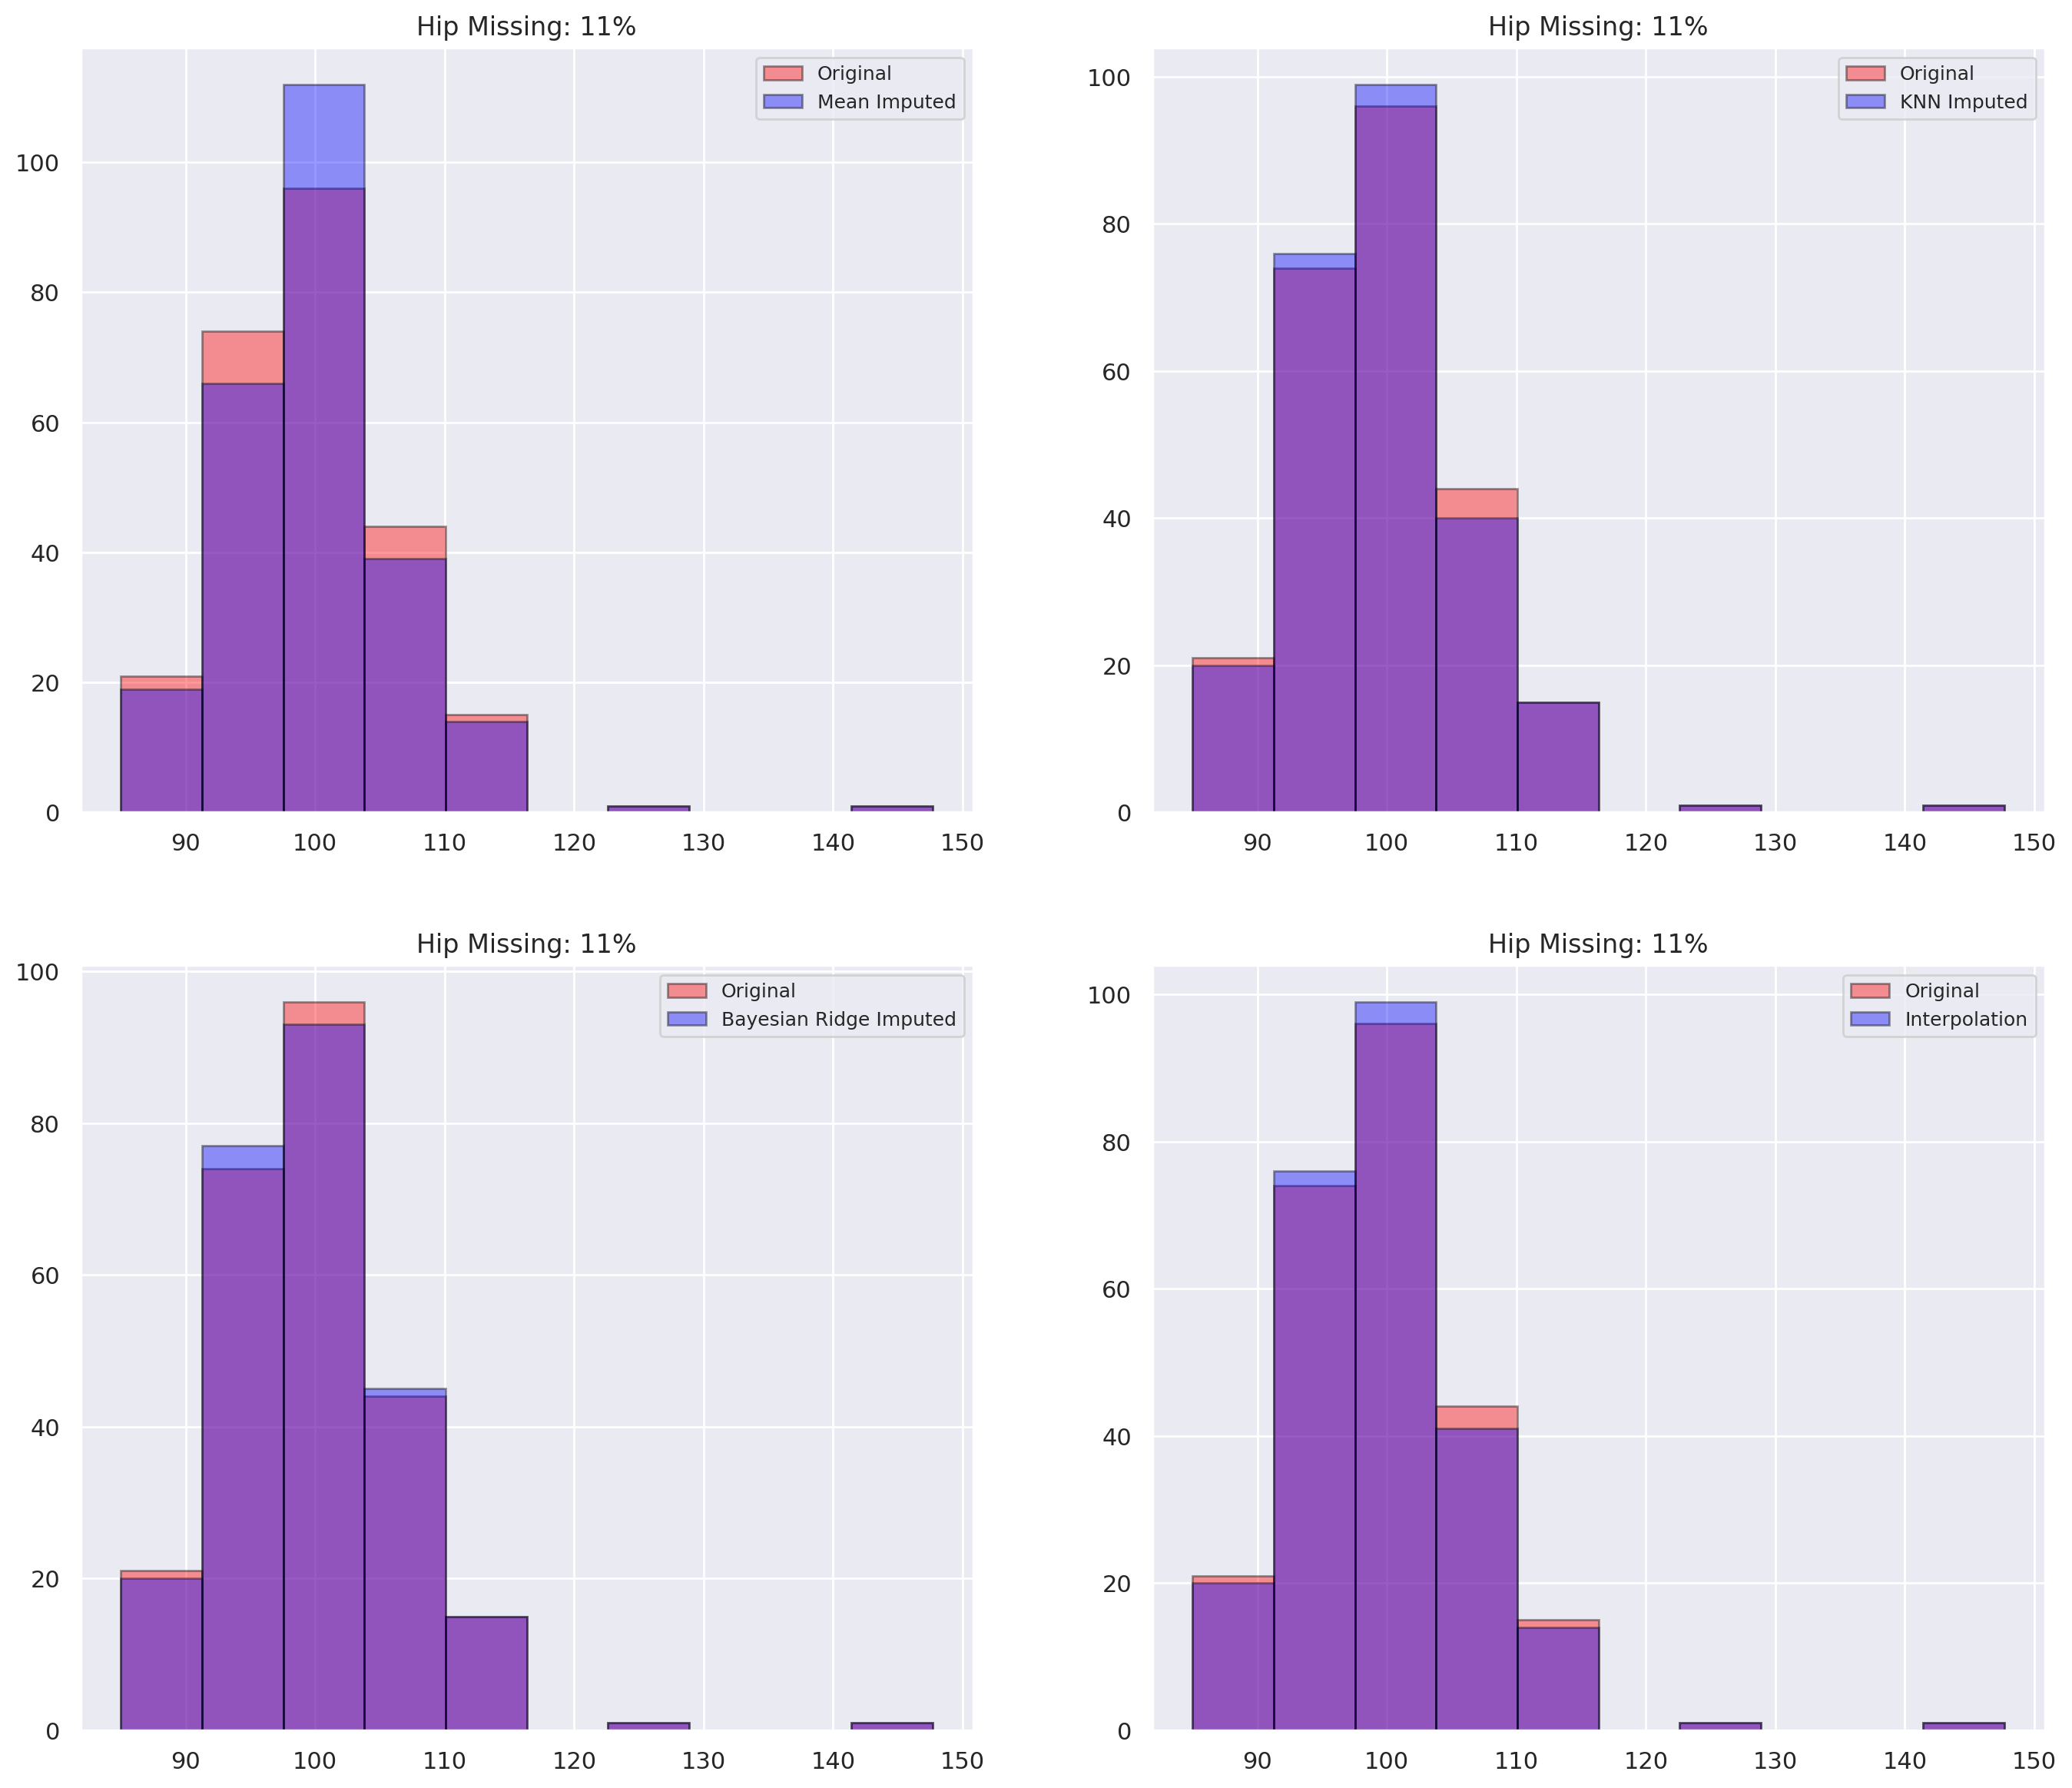

In [107]:
output_data["Hip"] = plot_imputations(d, data, "Hip")

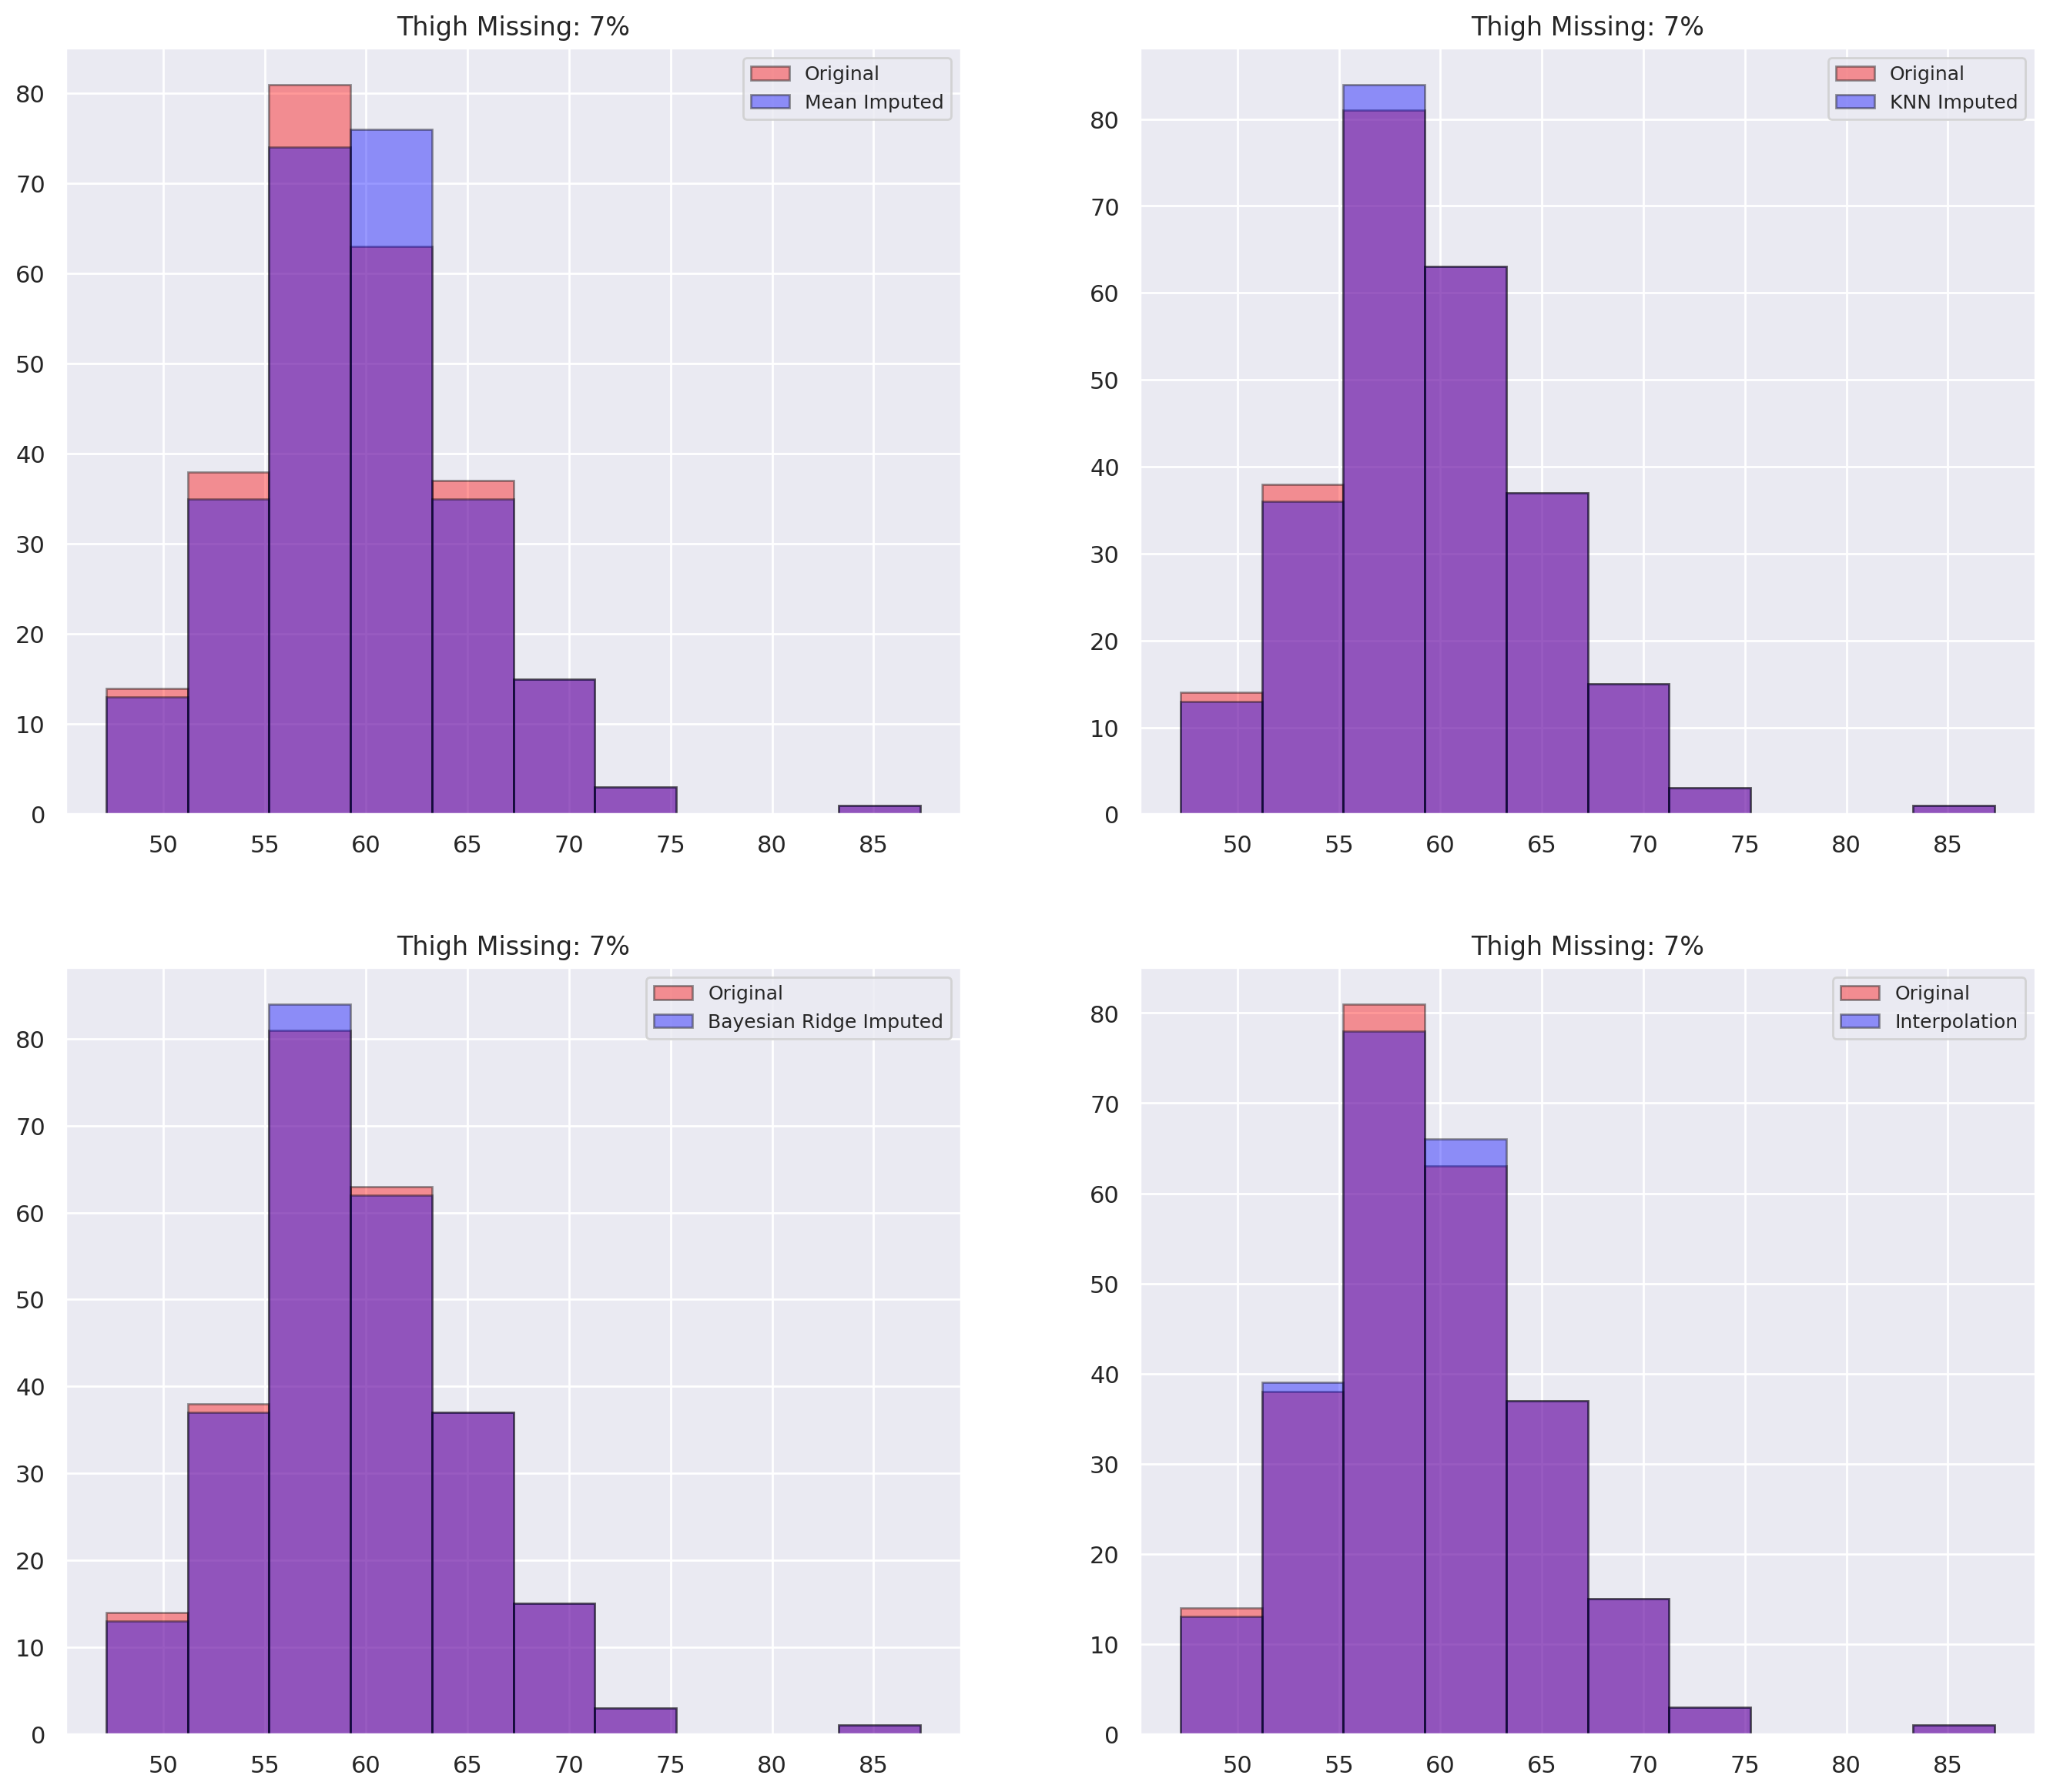

In [108]:
output_data["Thigh"] = plot_imputations(d, data, "Thigh")

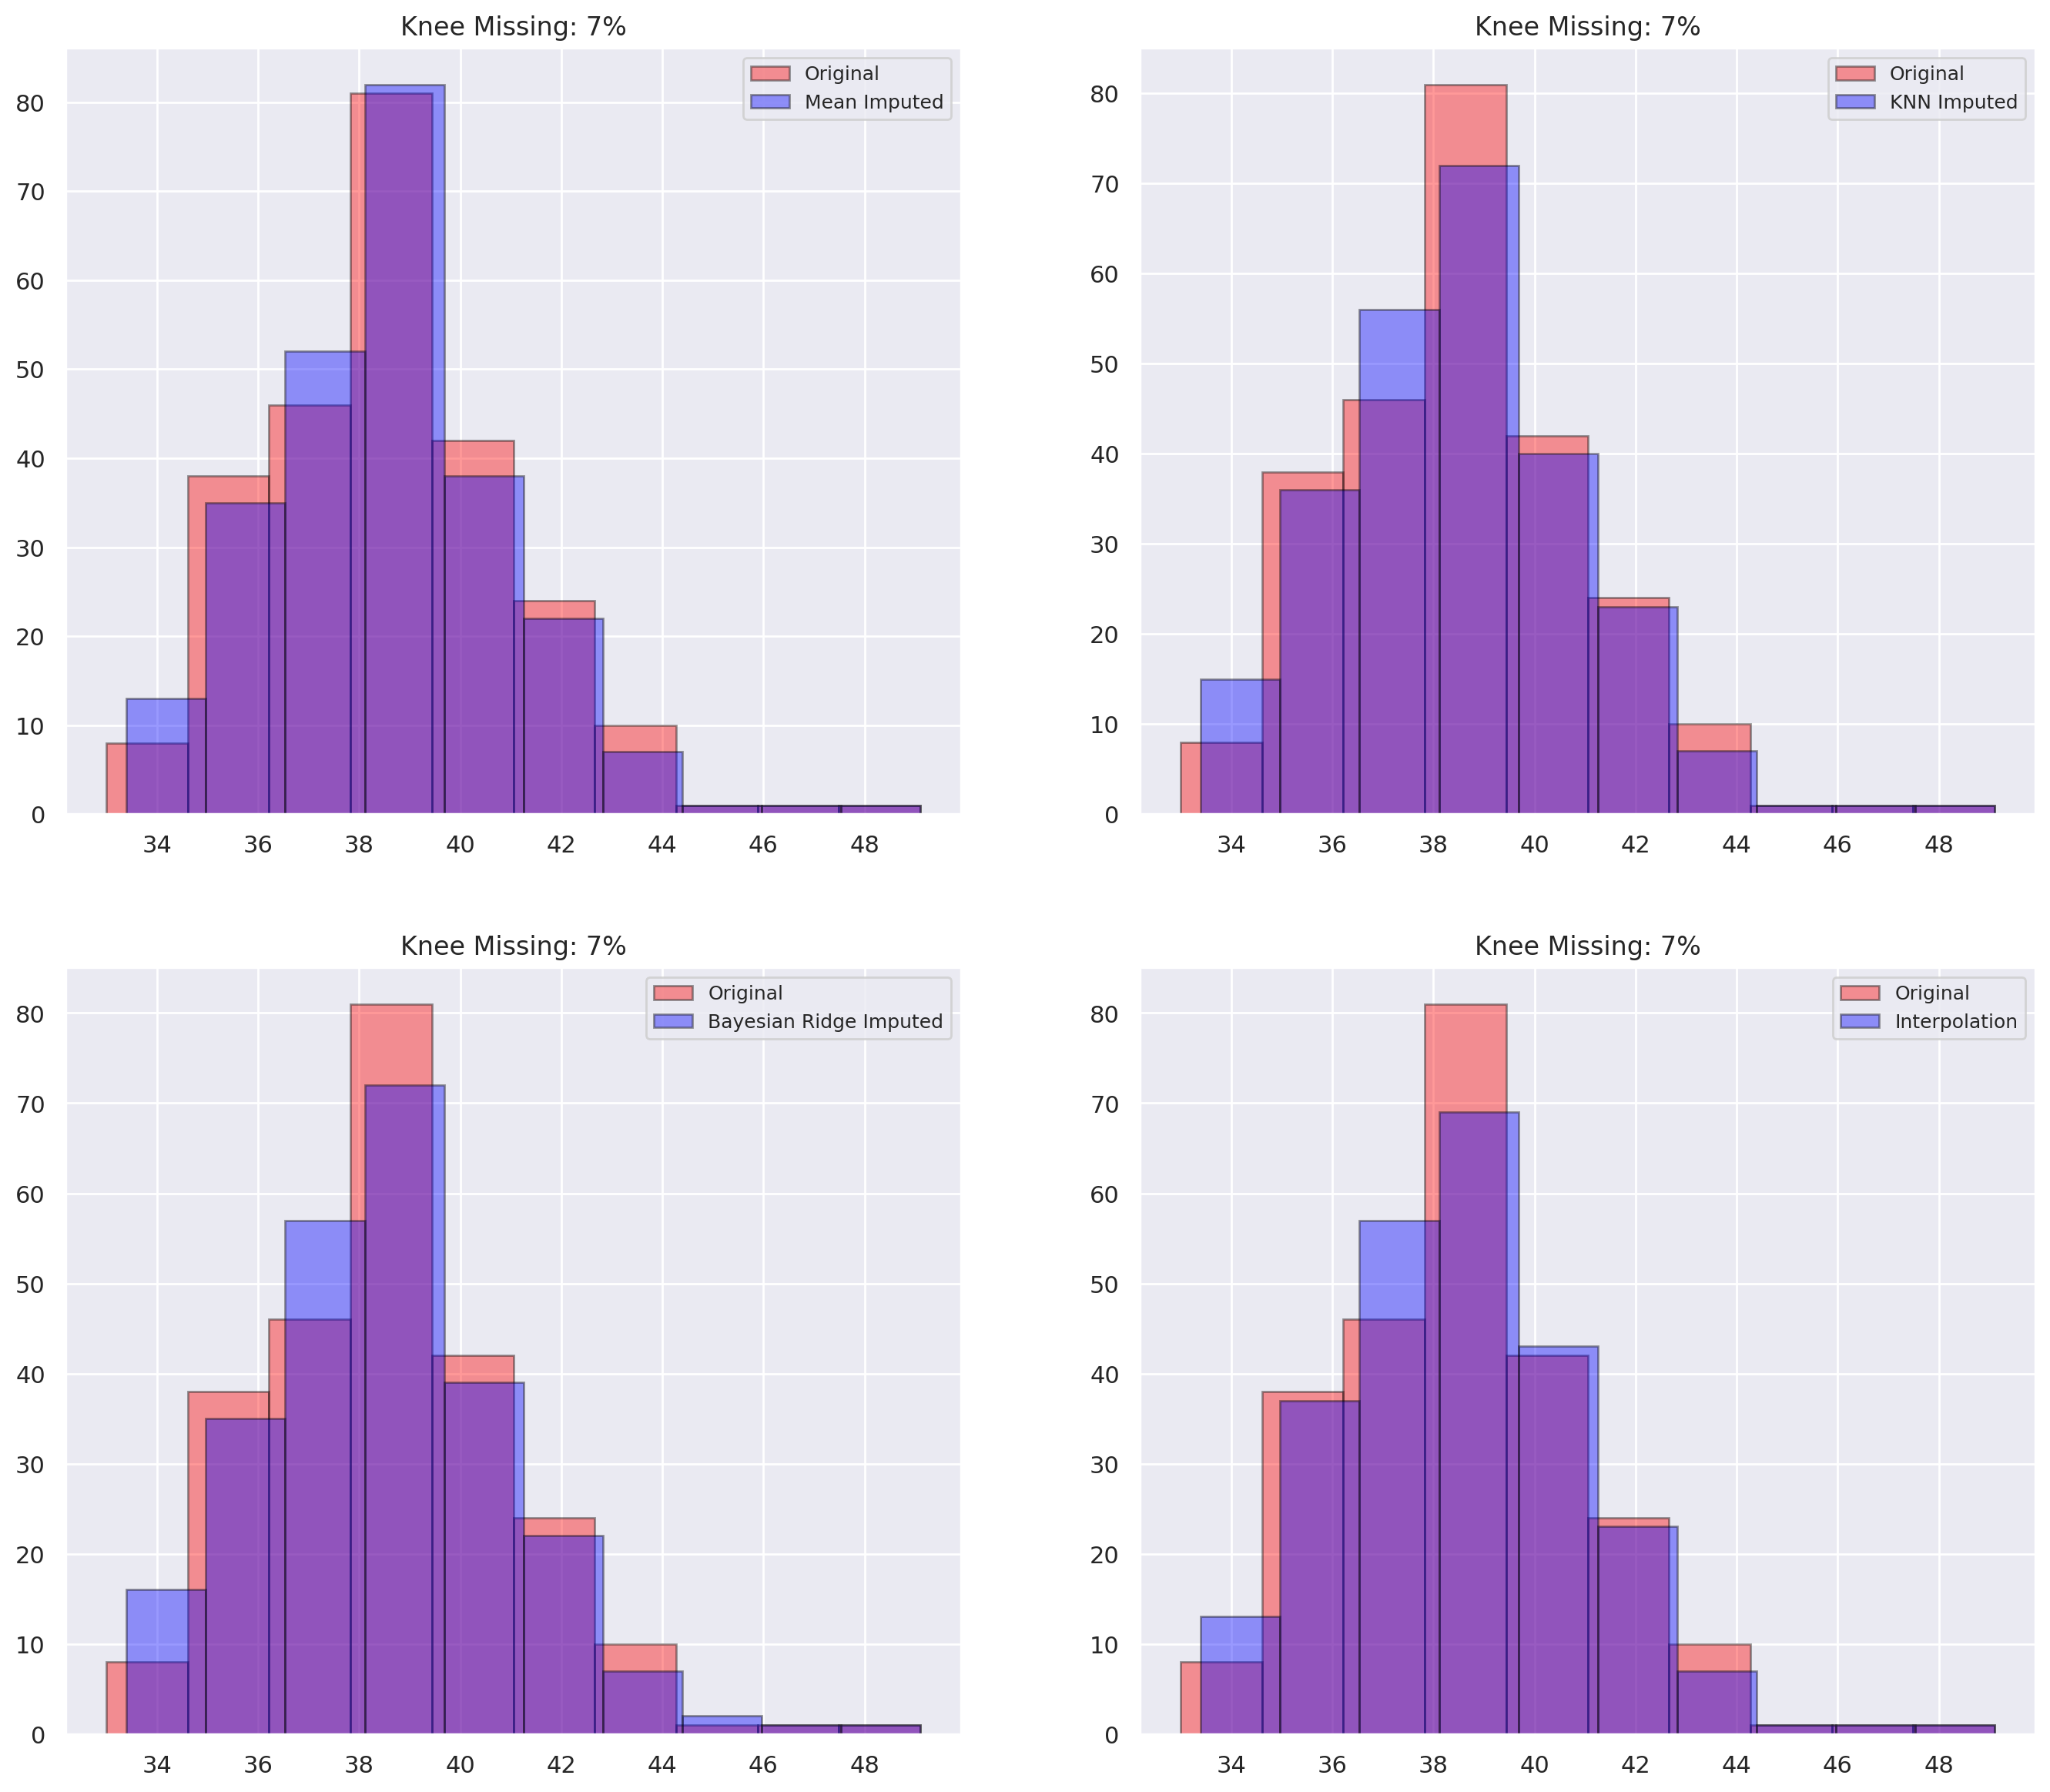

In [109]:
output_data["Knee"] = plot_imputations(d, data, "Knee")

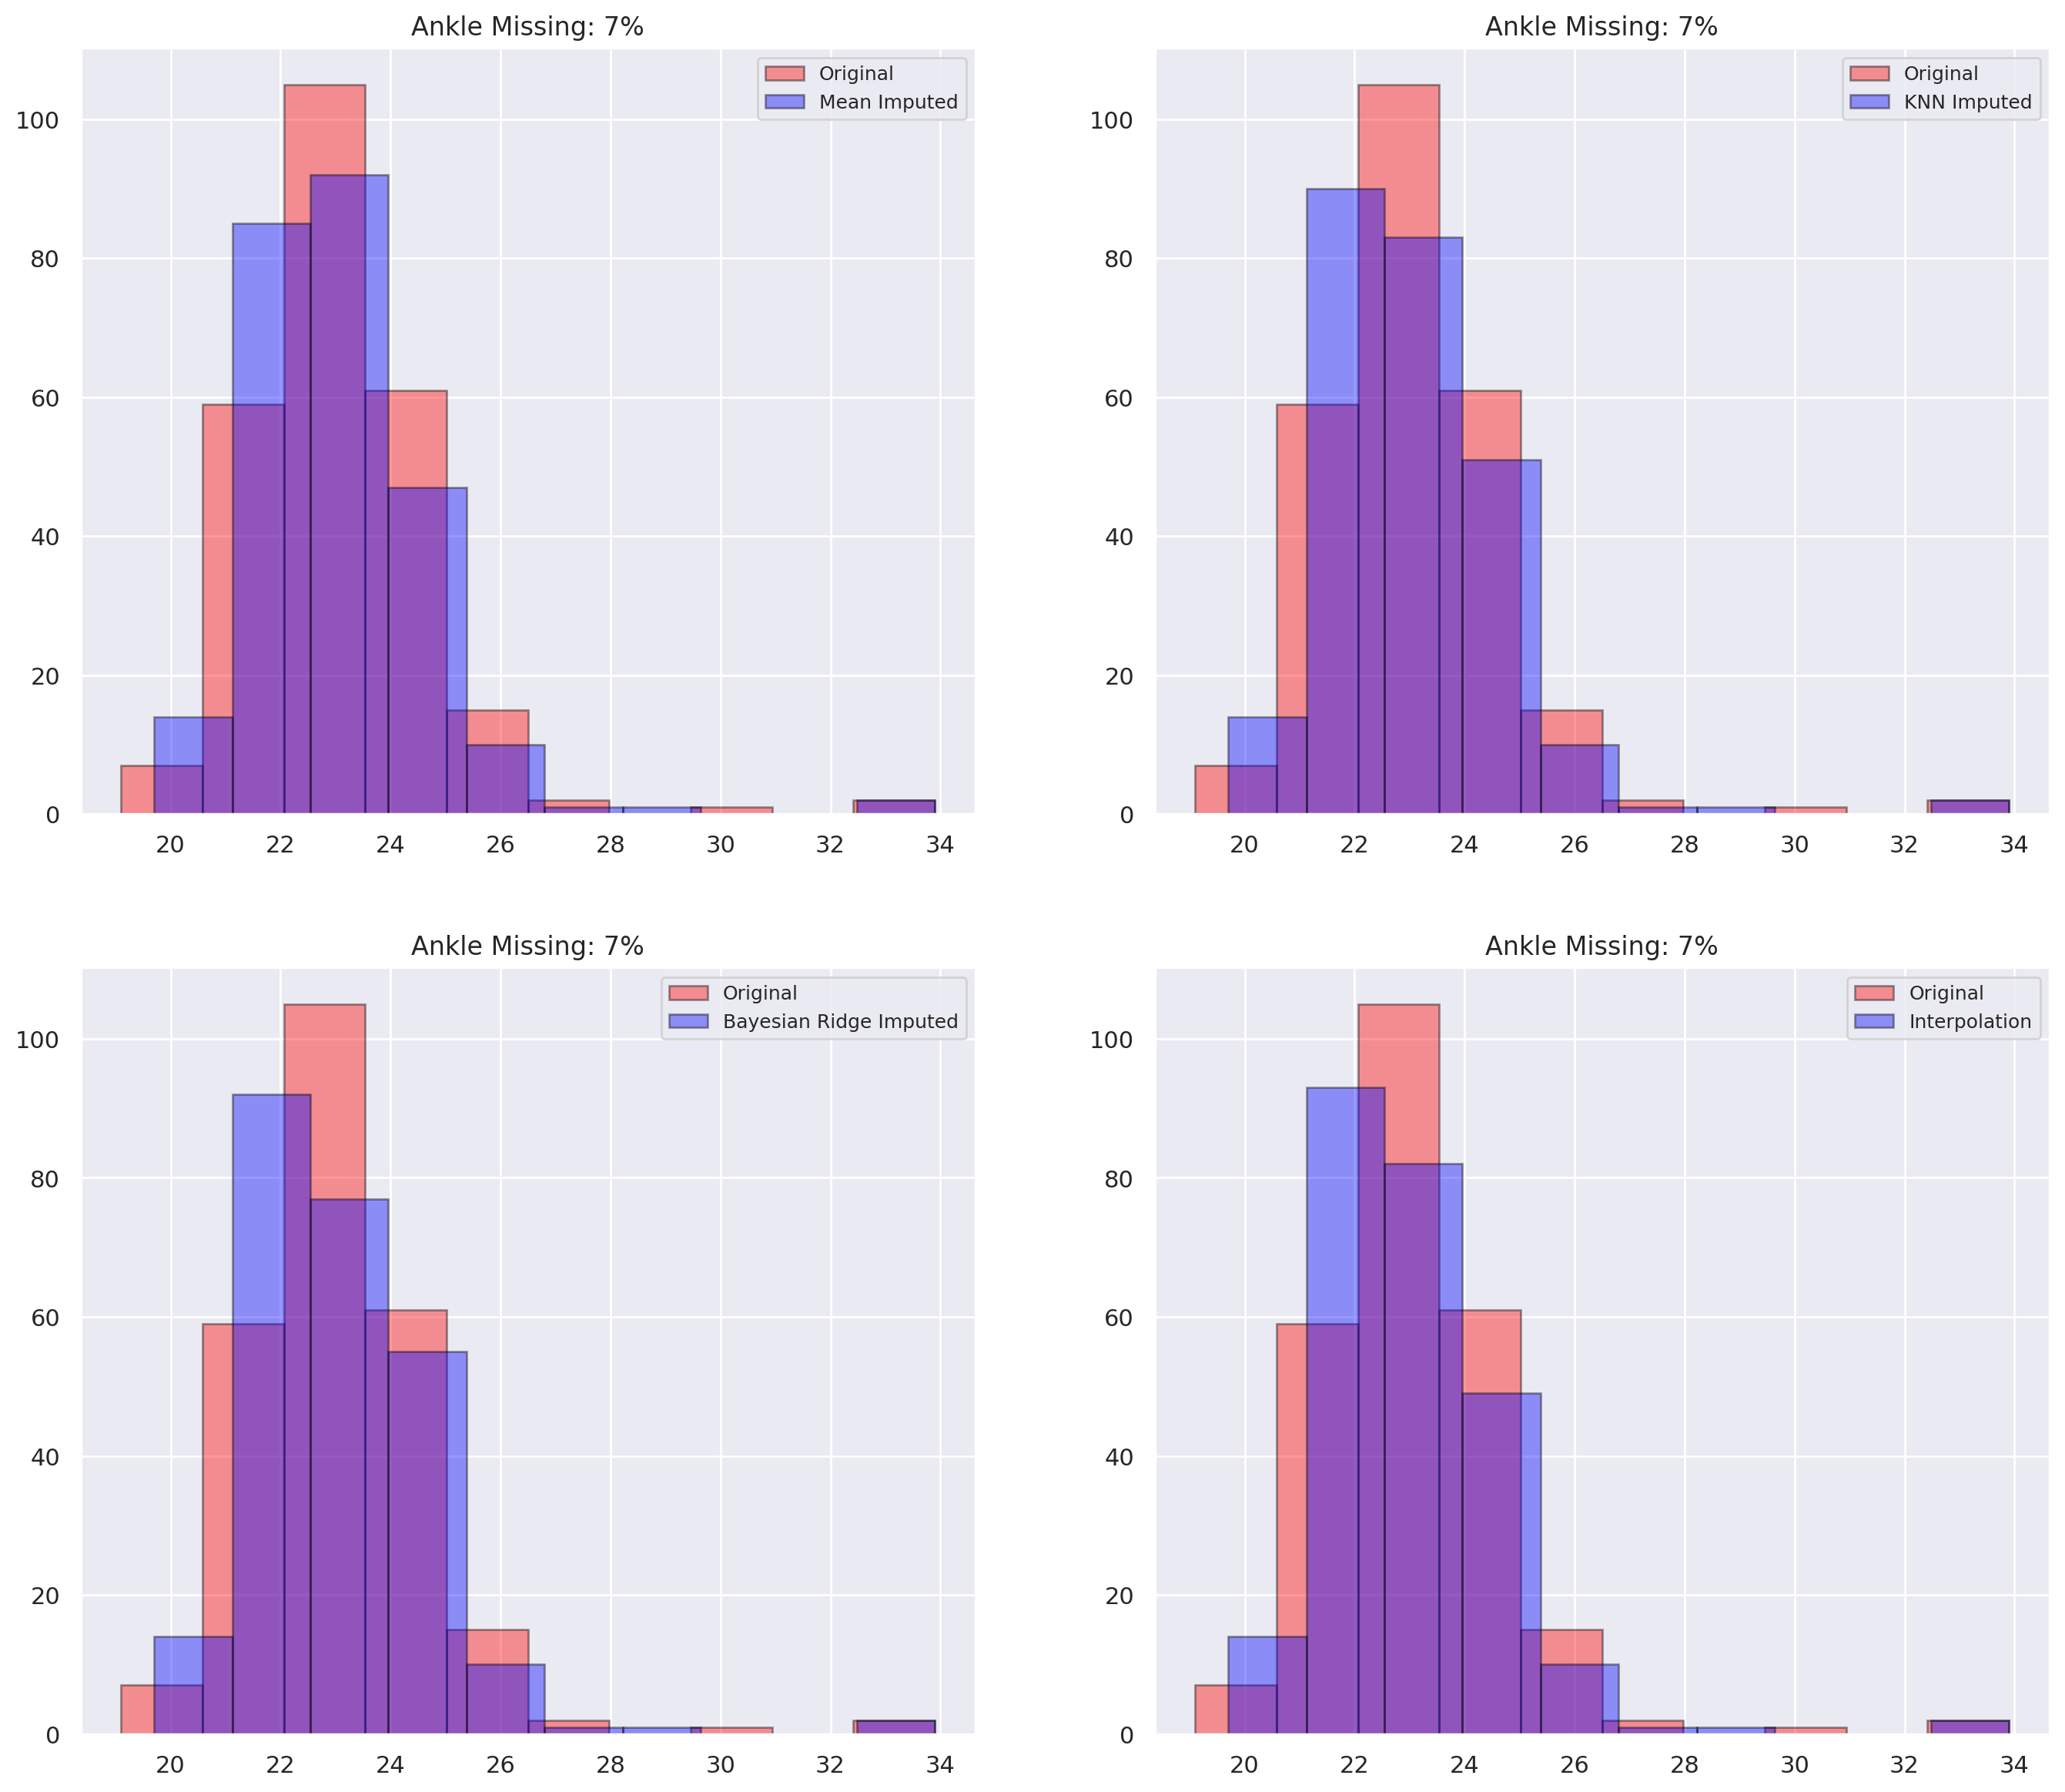

In [110]:
output_data["Ankle"] = plot_imputations(d, data, "Ankle")

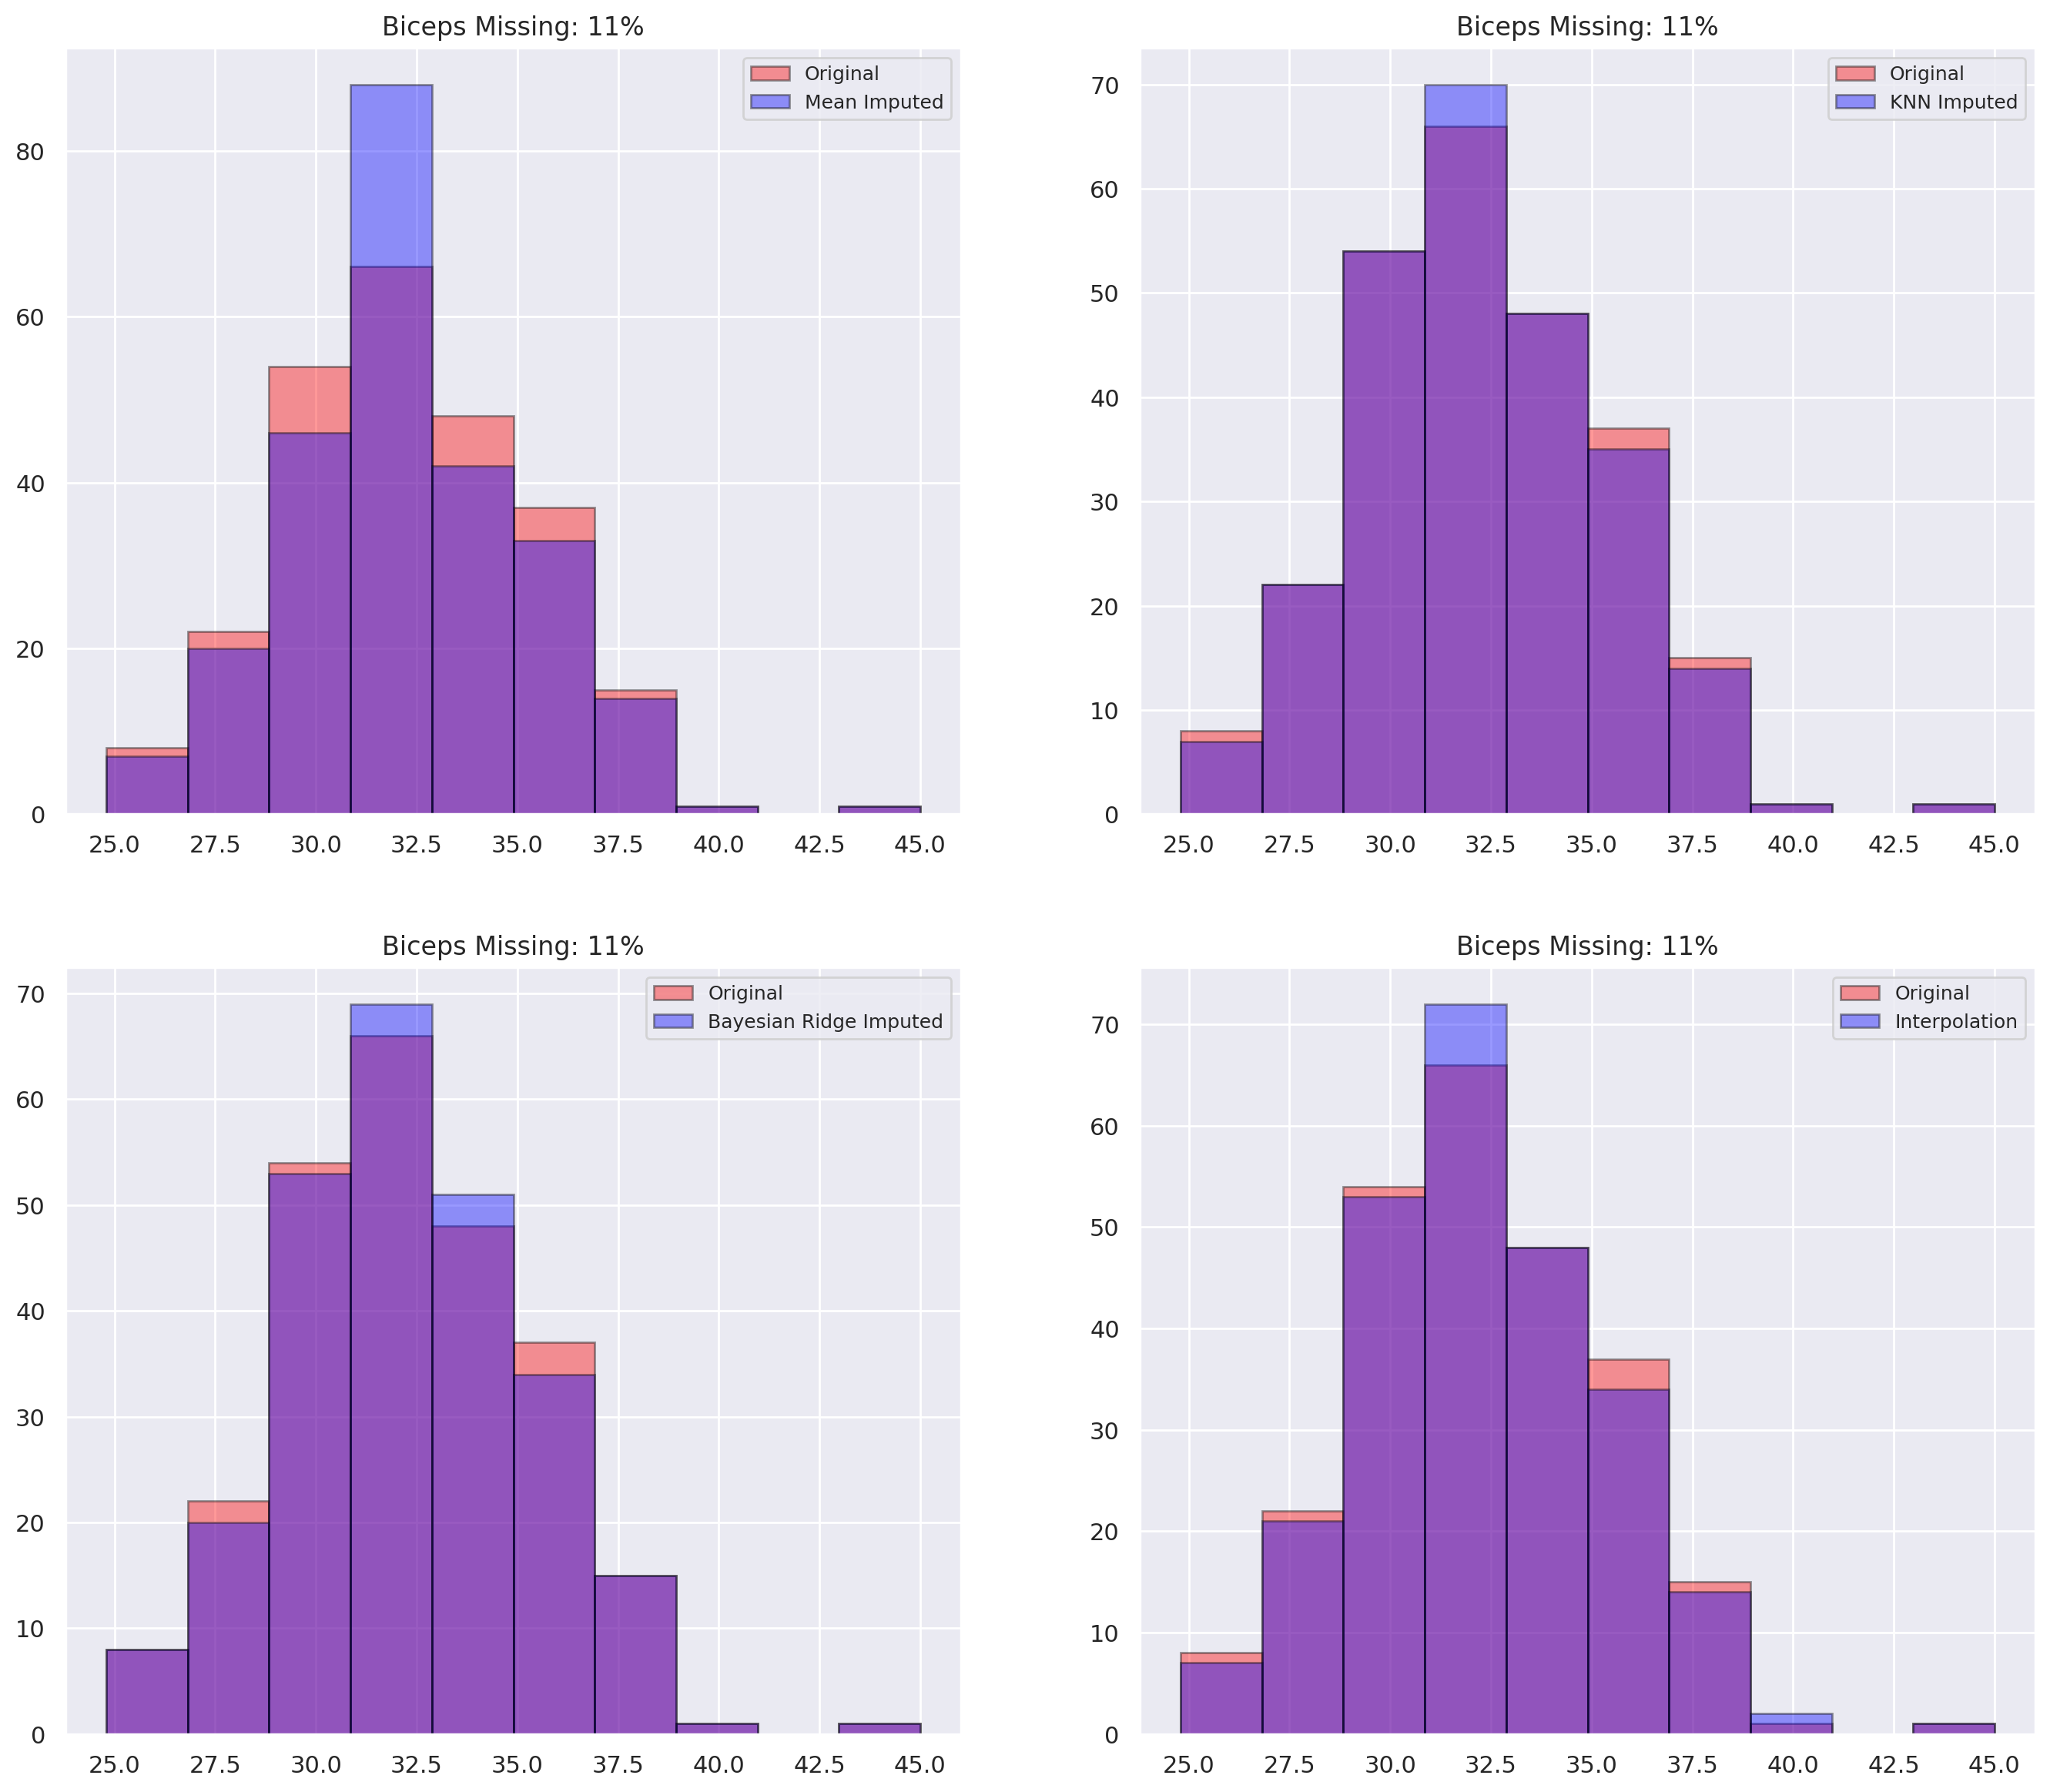

In [111]:
output_data["Biceps"] = plot_imputations(d, data, "Biceps")

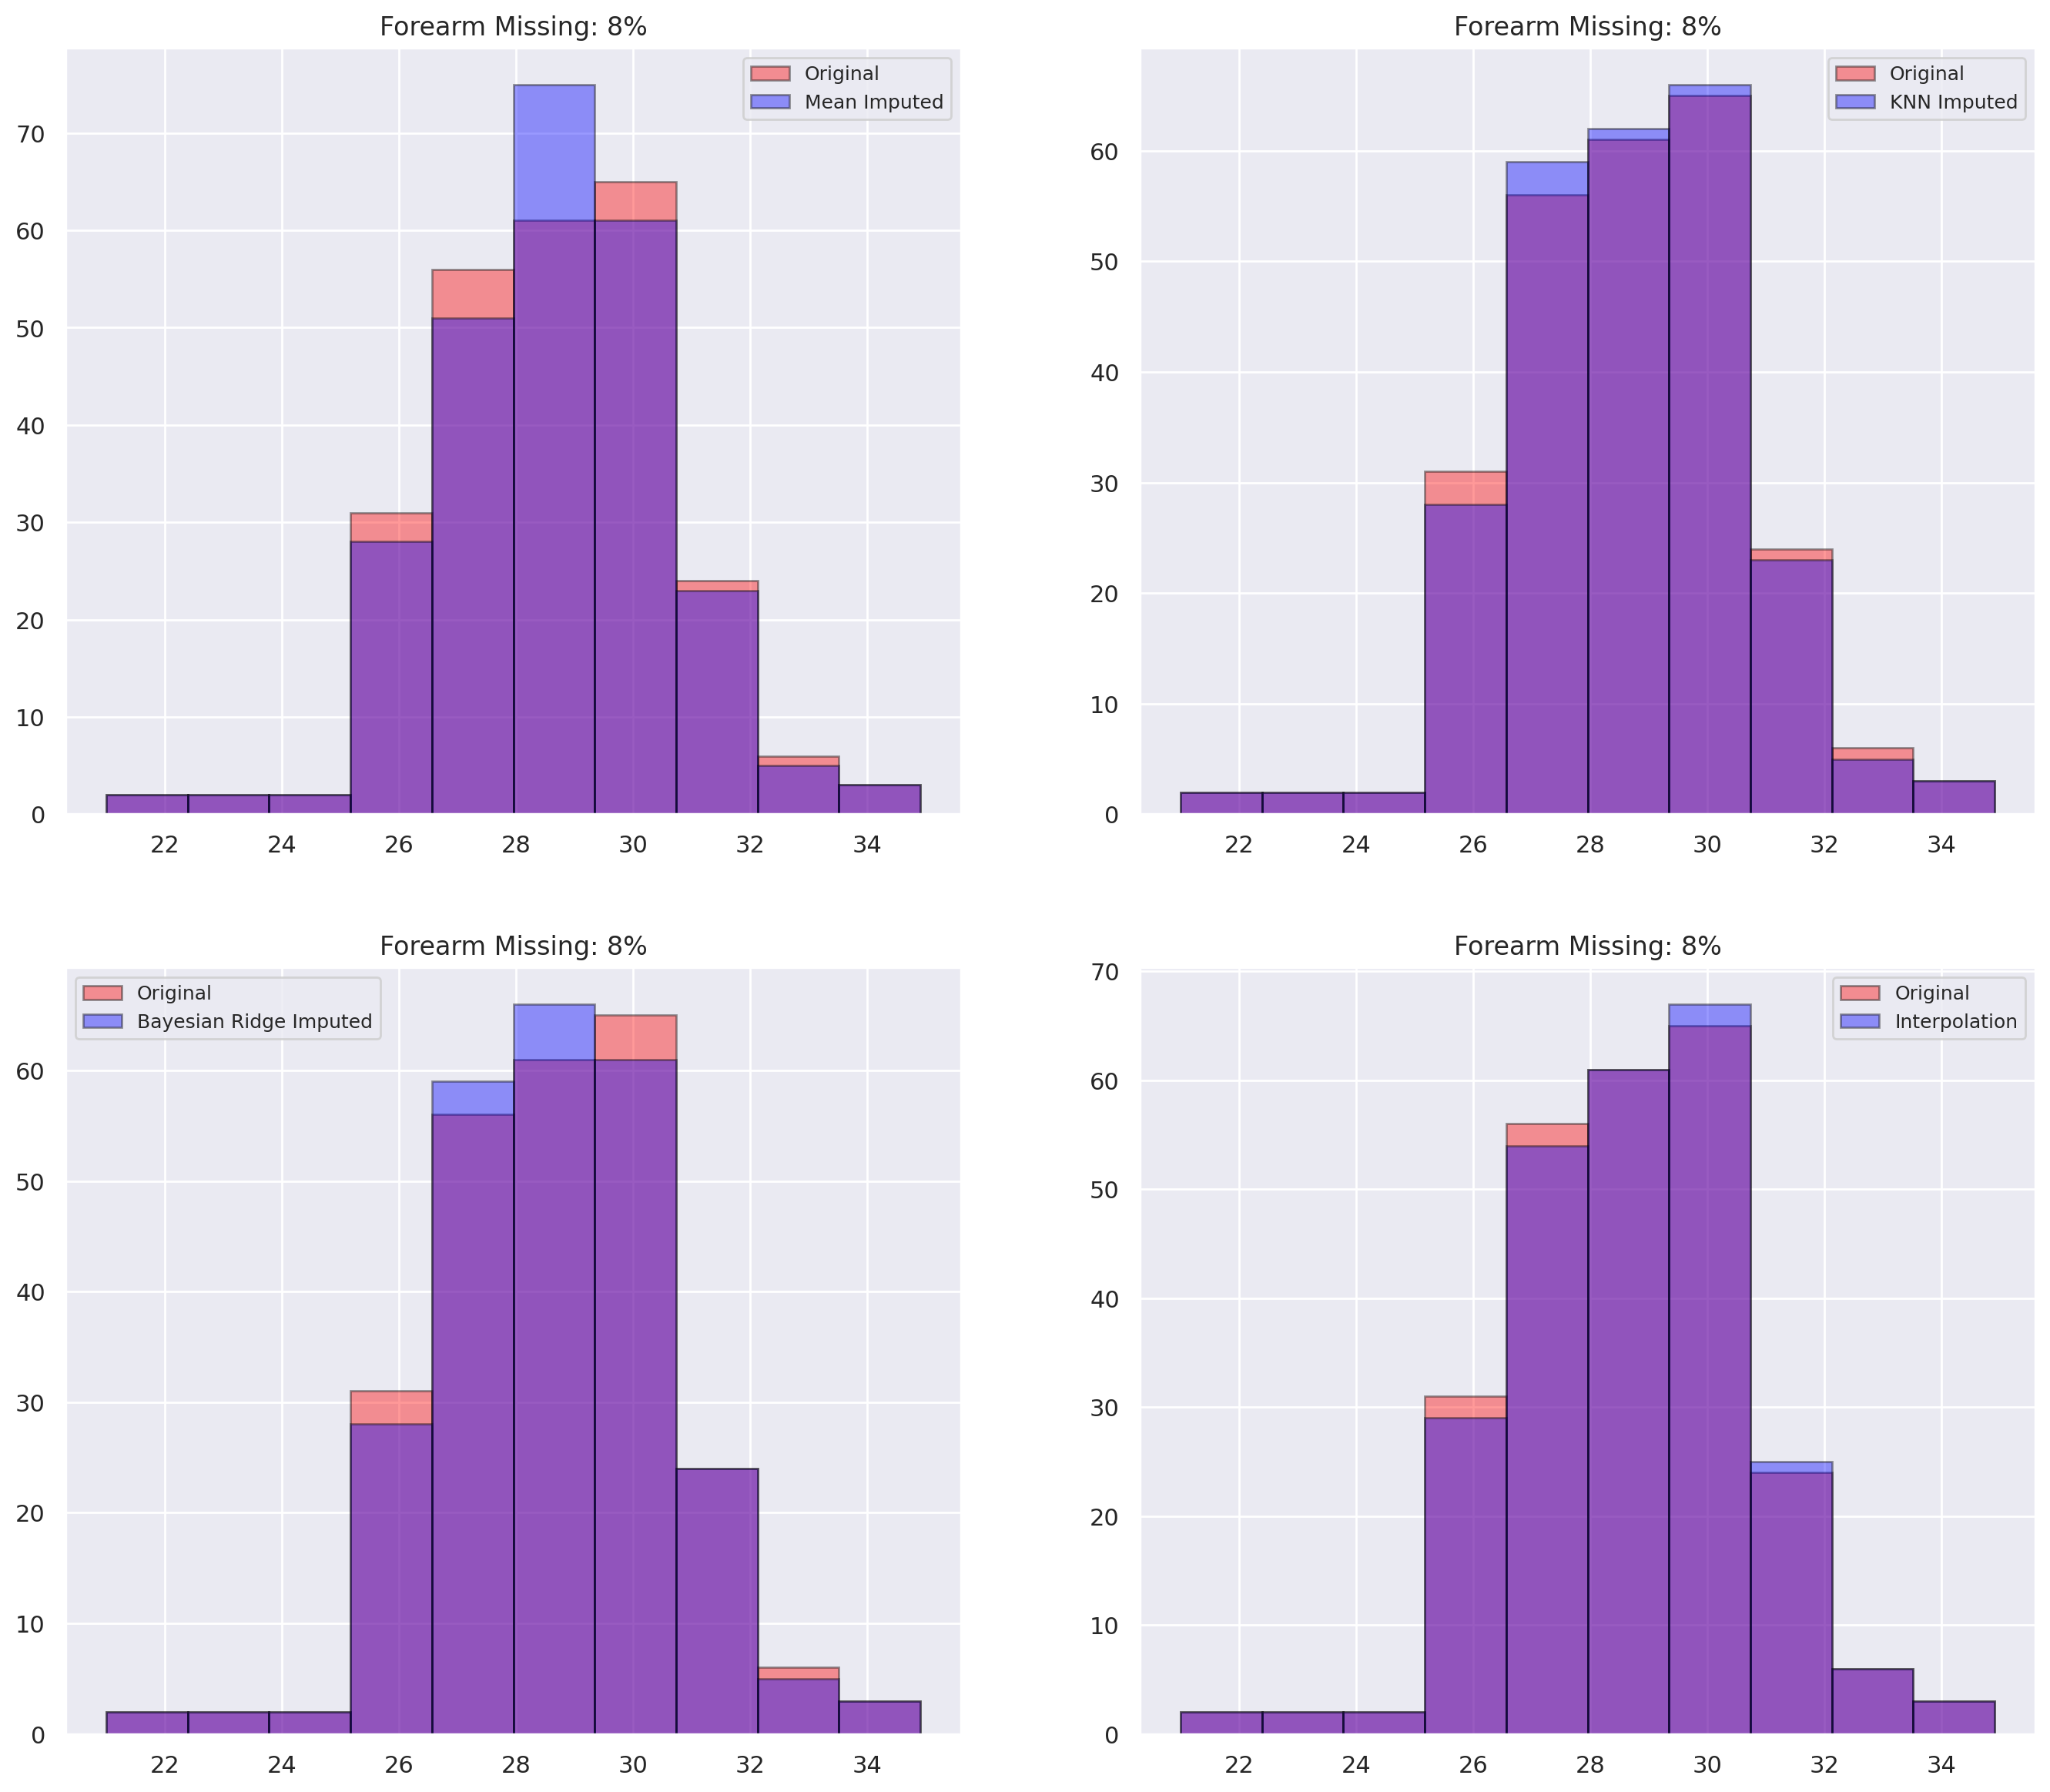

In [112]:
output_data["Forearm"] = plot_imputations(d, data, "Forearm")

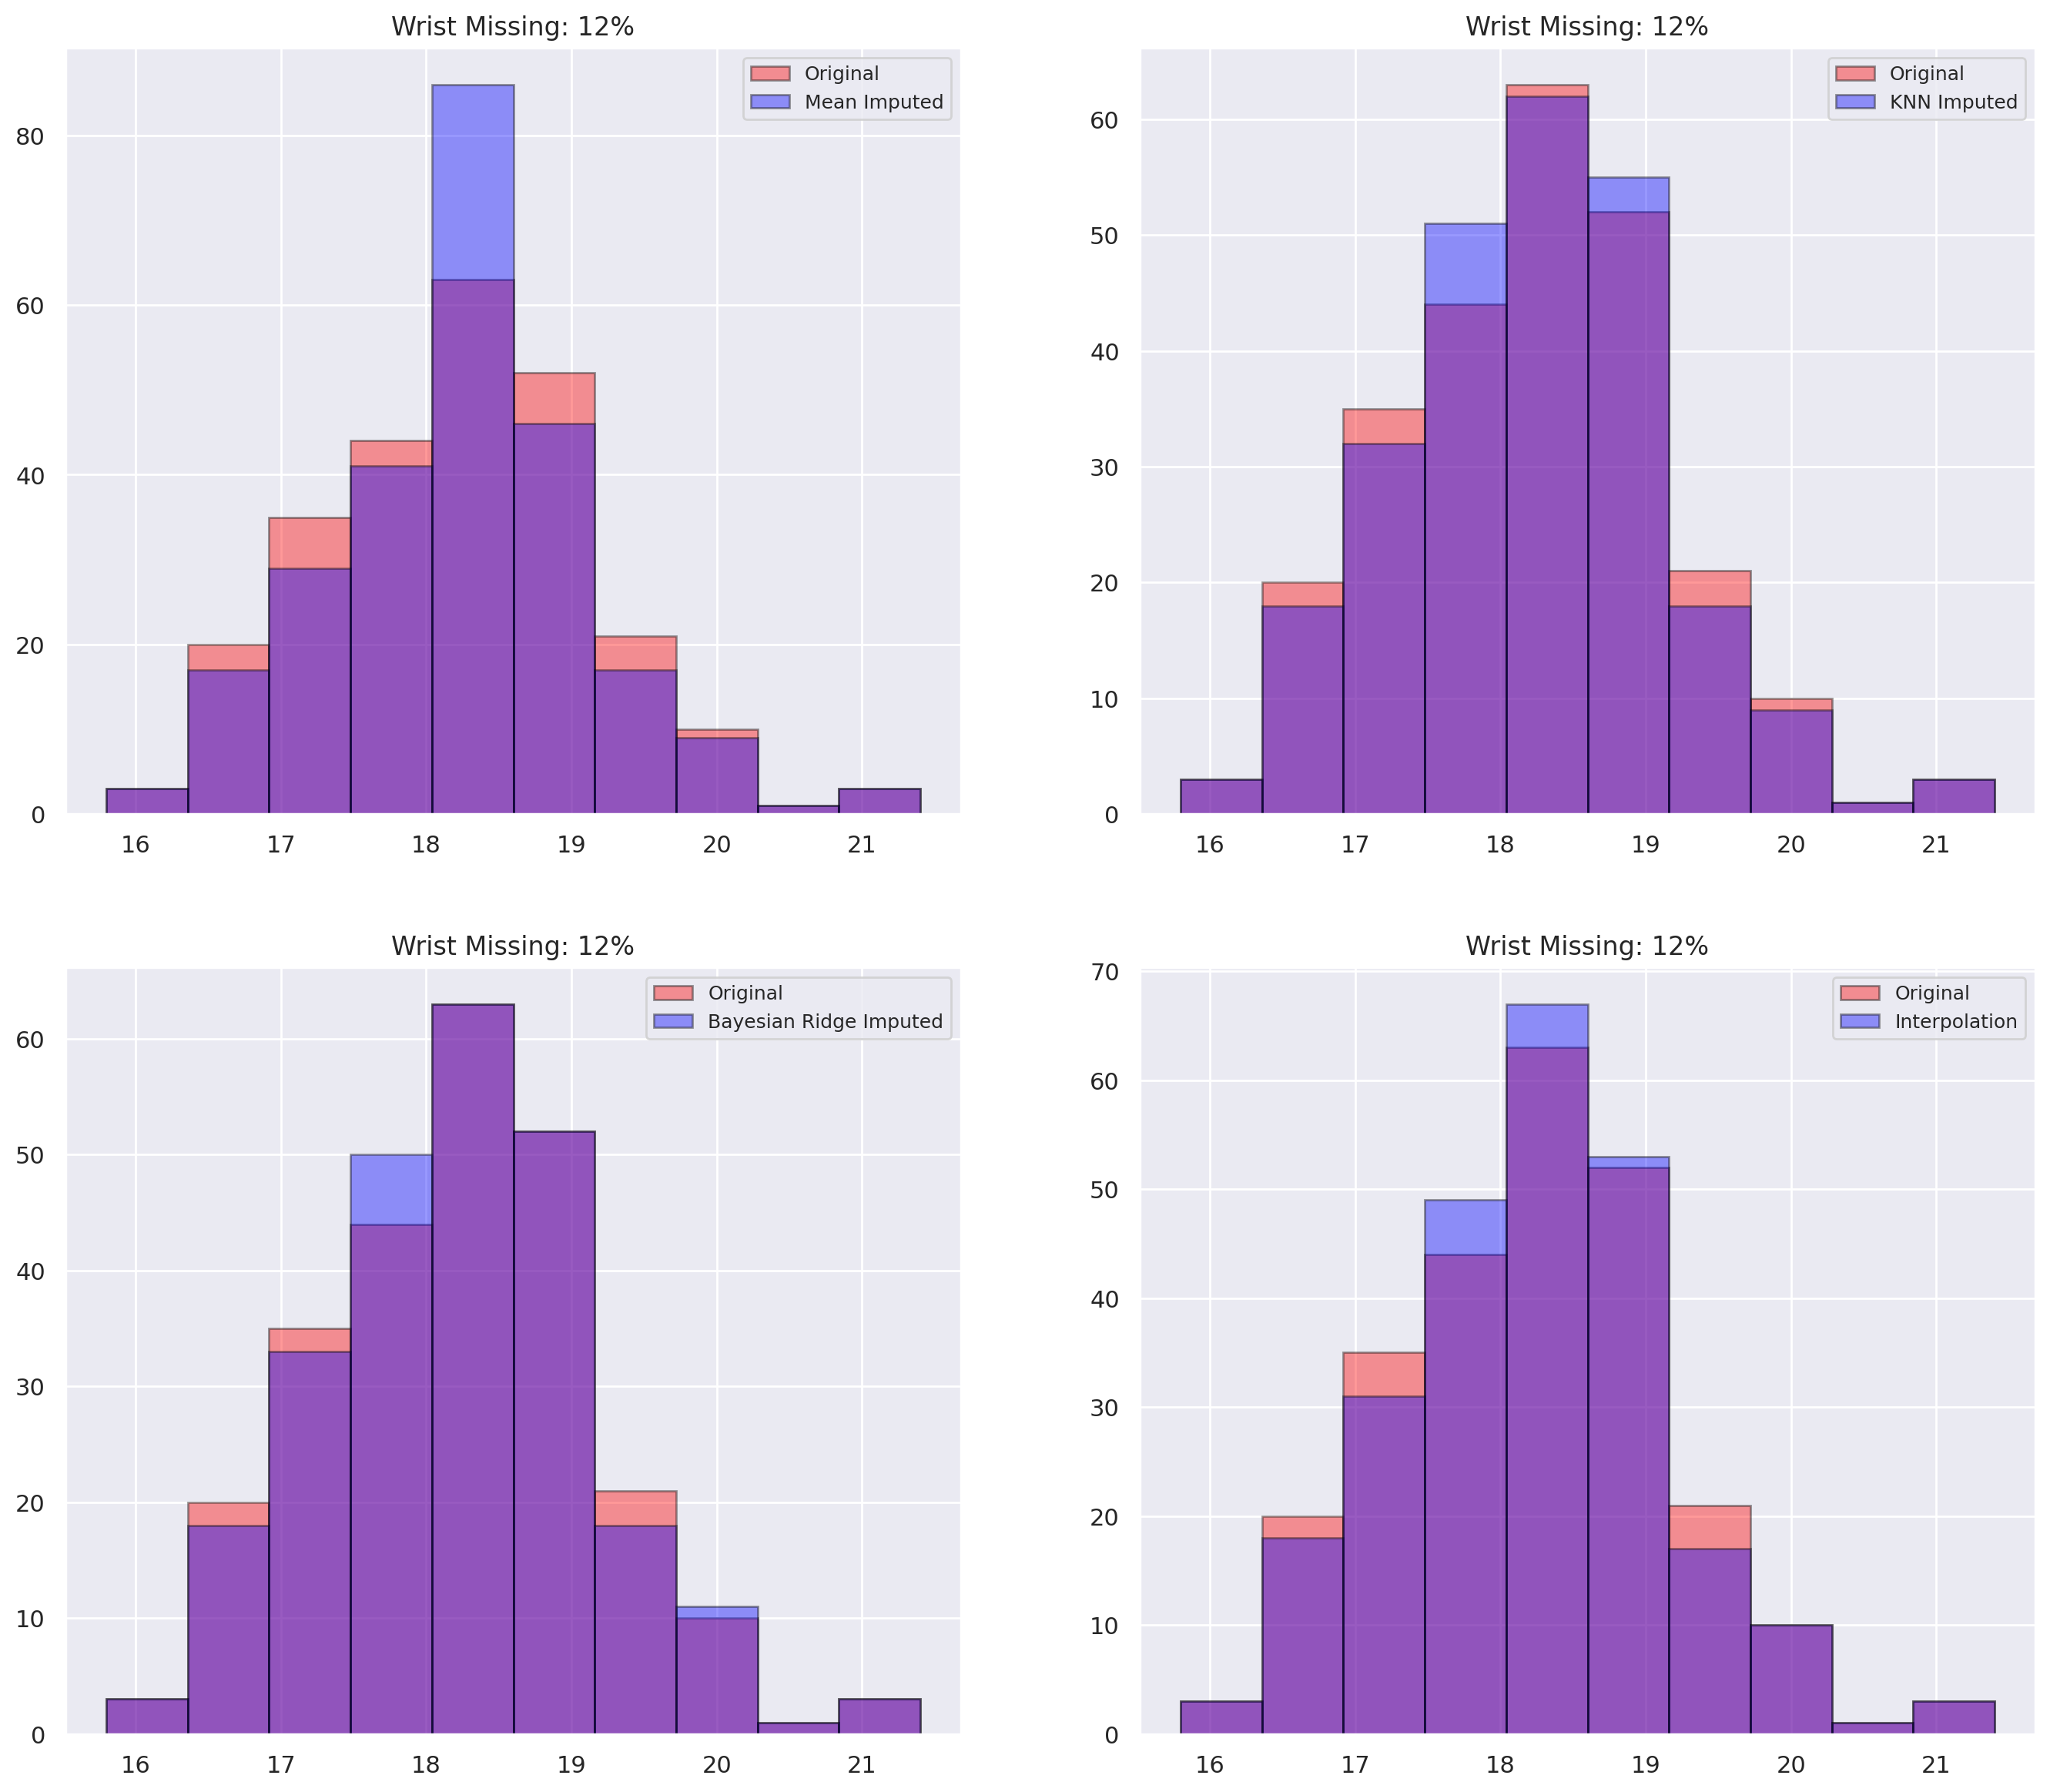

In [113]:
output_data["Wrist"] = plot_imputations(d, data, "Wrist")

In [114]:
output_data["BodyFat"] = data["BodyFat"]
output_data.to_csv("MD_managed_bodyfat.csv")

In [115]:
import numpy as np
from sklearn.metrics import mean_squared_error
MSE_sum_mean = 0
for column in d.columns:
    MSE_sum_mean += mean_squared_error(d[column], imputed_mean[column])
MSE_sum_mean = MSE_sum_mean/len(d.columns)
MSE_sum_mean

8.562198972439187

In [116]:
MSE_sum_KNN = 0
for column in d.columns:
    KNN_predicted = replace_and_plot(data, column)
    MSE_sum_KNN += mean_squared_error(d[column], KNN_predicted)
MSE_sum_KNN = MSE_sum_KNN/len(d.columns)
MSE_sum_KNN

2.8670771097449745

In [117]:
MSE_sum_MICE = 0
for column in d.columns:
    MSE_sum_MICE += mean_squared_error(d[column], imputed_BR[column])
MSE_sum_MICE = MSE_sum_MICE/len(d.columns)
MSE_sum_MICE

1.2073306390203271

In [118]:

interpolated = data.interpolate()
MSE_sum_interpol = 0
for column in d.columns:
    MSE_sum_interpol += mean_squared_error(d[column][2:], interpolated[column][2:])
MSE_sum_interpol = MSE_sum_interpol/len(d.columns)
MSE_sum_interpol

6.494216284515776

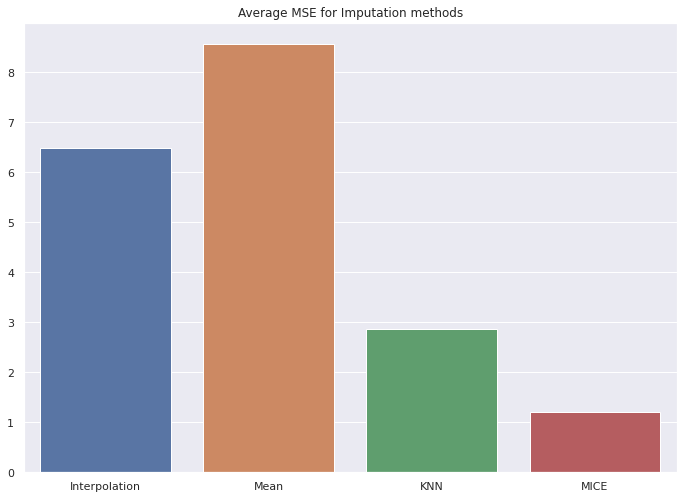

In [119]:
import seaborn as sns

sns.set(font_scale = 30)
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(y = [MSE_sum_interpol, MSE_sum_mean, MSE_sum_KNN, MSE_sum_MICE],x = ["Interpolation", "Mean", "KNN", "MICE"] ).set_title("Average MSE for Imputation methods")
